# Extract the CMIP6 and CMIP5 climate
- and save the global climate in 2100 (using the definition as in the IPCC AR6 WG1 report)
- attention: that means we assume here in this notebook a warming of 0.69°C between 1850-1900 and 1986-2005 (as done in the IPCC AR6 report)
    - in Rounce et al., they used 0.63°C of warming as they used the estimates from the older SROCC IPCC report

In [1]:
from oggm import utils
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import seaborn as sns


In [2]:
gcms_cmip6_2300 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list_2300.csv', index_col=0)  
gcms_cmip6 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)   

gcms_ssps = []
for ind in gcms_cmip6.loc[gcms_cmip6['var']=='pr'].index:
    gcms_ssps.append(f'{gcms_cmip6.loc[ind].gcm}_{gcms_cmip6.loc[ind].ssp}')
gcm_c = {}
for e,gcm in enumerate(['CanESM5', 'IPSL-CM6A-LR', 'CESM2-WACCM', 'MRI-ESM2-0',
       'ACCESS-CM2', 'ACCESS-ESM1-5']):
    gcm_c[gcm] = f'C{e}'

In [3]:
print(len(gcms_cmip6)/2)

73.0


In [4]:
past_warming = 0.69 # for IPCC AR6 WG1 report 

In [5]:
extract_cmip6_climate = False
if extract_cmip6_climate:
    pd_temp_ch_2100_2300 = pd.DataFrame(columns=['gcm', 'ssp','global_temp_ch_2081-2100_preindustrial',
                                                                  'global_temp_ch_2071-2100_preindustrial',
                                                                  'global_temp_ch_2281-2300_preindustrial'])
    for ssp in gcms_cmip6.ssp.unique():
        gcms_cmip6_sel = gcms_cmip6.loc[(gcms_cmip6.ssp ==ssp) & (gcms_cmip6['var'] =='tas')]
        for f in gcms_cmip6_sel.index:
            gcm = gcms_cmip6_sel.loc[f].gcm
            dtas_annual = xr.open_dataset(gcms_cmip6_sel.loc[f]['path'],
                                          use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()
            weight = np.cos(np.deg2rad(dtas_annual.lat))
            weight = weight/weight.sum()
            global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
            avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
            avg_2081_2100 = global_dtas_per_year.sel(year=slice('2081','2100')).mean().values
            avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
            avg_2271_2300 = global_dtas_per_year.sel(year=slice('2271','2300')).mean().values
            avg_2281_2300 = global_dtas_per_year.sel(year=slice('2281','2300')).mean().values

            temperature_increase_2081_2100_rel_preindustrial = avg_2081_2100- avg_1986_2005 + past_warming
            temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming
            temperature_increase_2271_2300_rel_preindustrial = avg_2271_2300- avg_1986_2005 + past_warming
            temperature_increase_2281_2300_rel_preindustrial = avg_2281_2300- avg_1986_2005 + past_warming

            pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{ssp}', 'global_temp_ch_2081-2100_preindustrial'] =  temperature_increase_2081_2100_rel_preindustrial
            pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{ssp}', 'global_temp_ch_2071-2100_preindustrial'] =  temperature_increase_2071_2100_rel_preindustrial
            pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{ssp}', 'global_temp_ch_2281-2300_preindustrial'] =  temperature_increase_2281_2300_rel_preindustrial
            pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{ssp}', 'global_temp_ch_2271-2300_preindustrial'] =  temperature_increase_2271_2300_rel_preindustrial

            pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{ssp}', 'gcm'] = gcm.upper()
            pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{ssp}', 'ssp'] = ssp
            
    for j in pd_temp_ch_2100_2300.index:
        temp_ch_2081_2100_rel_preind = pd_temp_ch_2100_2300.loc[j, 'global_temp_ch_2081-2100_preindustrial'] 
        if (temp_ch_2081_2100_rel_preind <=1.75) and ((temp_ch_2081_2100_rel_preind >=1.25)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+1.5°C'] = True
        if (temp_ch_2081_2100_rel_preind <=2.5) and ((temp_ch_2081_2100_rel_preind >=1.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+2.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=3.5) and ((temp_ch_2081_2100_rel_preind >=2.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+3.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=4.5) and ((temp_ch_2081_2100_rel_preind >=3.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+4.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=5.5) and ((temp_ch_2081_2100_rel_preind >=4.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+5.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=6.5) and ((temp_ch_2081_2100_rel_preind >=5.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+6.0°C'] = True
    
    for j in pd_temp_ch_2100_2300.index:
        temp_ch_2071_2100_rel_preind = pd_temp_ch_2100_2300.loc[j, 'global_temp_ch_2071-2100_preindustrial'] 
        if (temp_ch_2071_2100_rel_preind <=1.5):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+1.5°C'] = True
        elif (temp_ch_2071_2100_rel_preind<=2.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+2.0°C'] = True
        elif (temp_ch_2071_2100_rel_preind<=3.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+3.0°C'] = True
        elif (temp_ch_2071_2100_rel_preind<=4.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+4.0°C'] = True
        elif (temp_ch_2071_2100_rel_preind>4.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_>4.0°C'] = True
    pd_temp_ch_2100_2300.to_csv('Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip6_gcms_ipcc_ar6_def.csv')


In [6]:
pd_temp_ch_2100_2300 = pd.read_csv('Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip6_gcms_ipcc_ar6_def.csv', index_col=0)

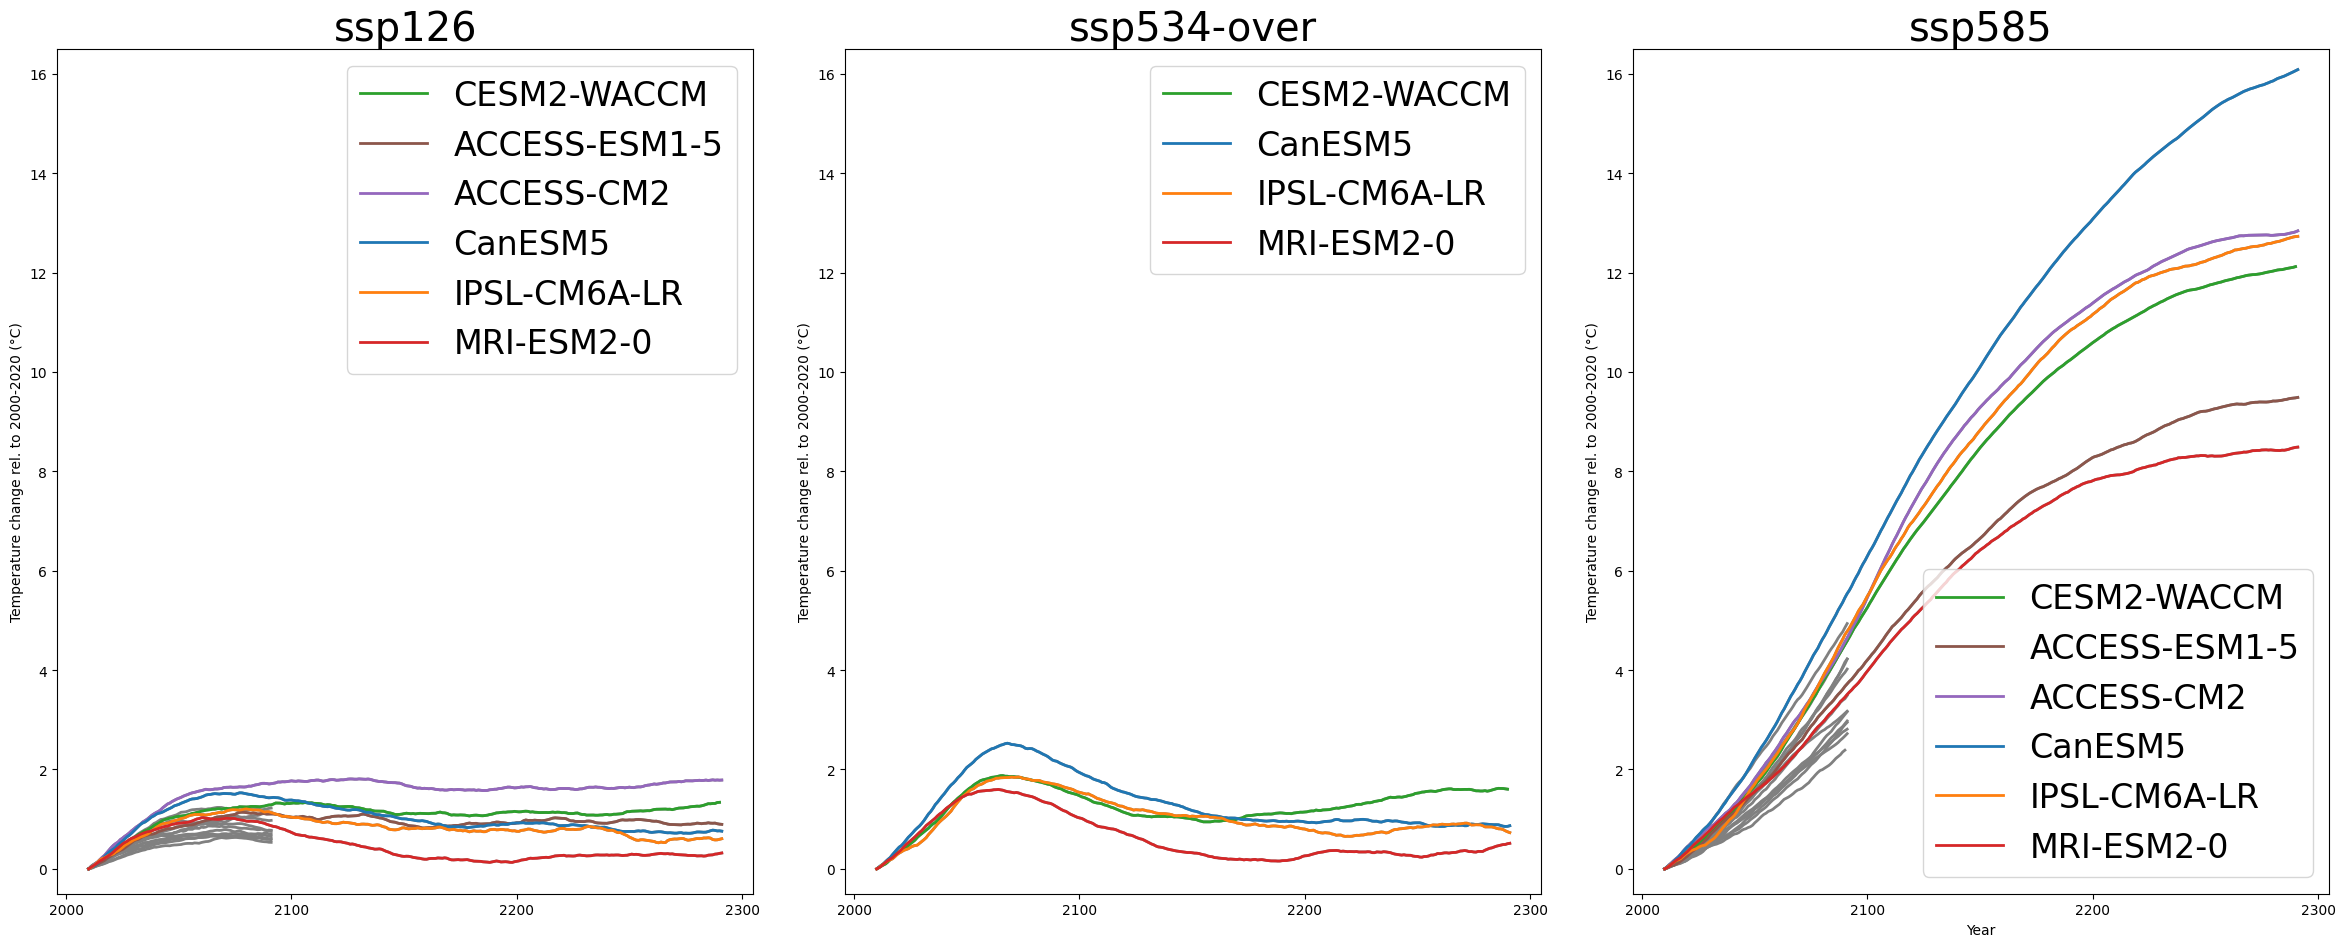

In [7]:
fig,axs = plt.subplots(1,3,figsize=(24,10))
plt.rc('font', size=24)
for ax,ssp in  zip(axs,['ssp126','ssp534-over','ssp585']):
    gcms_cmip6_2300_over = gcms_cmip6.loc[(gcms_cmip6.ssp ==ssp) & (gcms_cmip6['var'] =='tas')]
    for f in gcms_cmip6_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('2000','2300')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()
        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=20, center=True).mean()
        ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
                color= 'grey')
ax.set_xlabel('Year')
     
for ax,ssp in  zip(axs,['ssp126','ssp534-over','ssp585']):
    gcms_cmip6_2300_over = gcms_cmip6_2300.loc[(gcms_cmip6_2300.ssp ==ssp) & (gcms_cmip6_2300['var'] =='tas')]
    for f in gcms_cmip6_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('2000','2300')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=20,
                                                                                    center=True).mean()
        ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
                label=gcms_cmip6_2300_over.loc[f].gcm, 
                color= gcm_c[gcms_cmip6_2300_over.loc[f].gcm])
    ax.set_ylim([-0.5,16.5])
    ax.set_ylabel('Temperature change rel. to 2000-2020 (°C)')
    ax.legend()
    ax.set_title(ssp)
    
ax.set_xlabel('Year')

plt.tight_layout()
#plt.savefig('gcm_global_temp_change_cmip6_ipcc_ar6_def.png')

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(20,10))

plt.rc('font', size=24)
for ax,ssp in  zip(axs,['ssp126','ssp534-over']): #,'ssp585']):
    gcms_cmip6_2300_over = gcms_cmip6.loc[(gcms_cmip6.ssp ==ssp) & (gcms_cmip6['var'] =='tas')]
    for f in gcms_cmip6_2300_over.index.sort_values():
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('2000','2300')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=20, center=True).mean()
        ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
                color= 'grey')
ax.set_xlabel('Year')

for ax,ssp in  zip(axs,['ssp126','ssp534-over']): #,'ssp585']):
    gcms_cmip6_2300_over = gcms_cmip6_2300.loc[(gcms_cmip6_2300.ssp ==ssp) & (gcms_cmip6_2300['var'] =='tas')]
    for f in gcms_cmip6_2300_over.index.sort_values():
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('2000','2300')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=20, center=True).mean()
        ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
                label=gcms_cmip6_2300_over.loc[f].gcm, 
                color= gcm_c[gcms_cmip6_2300_over.loc[f].gcm])
    ax.set_ylim([-0.5,16.5])
    ax.set_ylabel('Temperature change relative to 2000-2020 (°C)')
    ax.legend()
    ax.set_title(ssp)
    
ax.set_xlabel('Year')
plt.tight_layout()
#plt.savefig('gcm_global_temp_change_cmip6_no_ssp585_ipcc_ar6_def.png')

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(20,10))
plt.rc('font', size=24)

for ax,ssp in  zip(axs,['ssp126','ssp534-over']):
    gcms_cmip6_2300_over = gcms_cmip6_2300.loc[(gcms_cmip6_2300.ssp ==ssp) & (gcms_cmip6_2300['var'] =='tas')]
    for f in gcms_cmip6_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'], use_cftime=True).sel(time=slice('2000','2300')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=20, center=True).mean()
        ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
                label=gcms_cmip6_2300_over.loc[f].gcm,
               color= gcm_c[gcms_cmip6_2300_over.loc[f].gcm])
    ax.set_ylim([-0.1,2.7])

    ax.set_ylabel('Temperature change relative to 2000-2020 (°C)')
    ax.legend()
    ax.set_title(ssp)

- already globally, they are extremely different ... , regionally it will be even stronger discrepancies ... 

## CMIP5 

In [9]:
gcms_cmip5_2300 = pd.read_csv('/home/www/oggm/cmip5-ng/all_gcm_list_2300.csv', index_col=0).reset_index(drop=True) 
gcms_cmip5 = pd.read_csv('/home/www/oggm/cmip5-ng/all_gcm_list.csv', index_col=0).reset_index(drop=True)   
# we have used the regular interpolationgcms_cmip5.loc[gcms_cmip5.interpolation == '_g025']
gcms_rcps = []
for ind in gcms_cmip5.loc[gcms_cmip5['var']=='pr'].index:
    gcms_rcps.append(f'{gcms_cmip5.loc[ind].gcm}_{gcms_cmip5.loc[ind].rcp}')
gcm_c5 = {}
for e,gcm in enumerate(['CanESM2', 'MPI-ESM-LR', 'CESM1-CAM5', 'CSIRO-Mk3-6-0',
       'NorESM1-M', 'CCSM4']):
    gcm_c5[gcm] = f'C{e}'

In [12]:
extract_cmip5_climate = False
if extract_cmip5_climate:
    pd_temp_ch_2100_2300 = pd.DataFrame(#index=gcms_rcps,
                                        columns=['gcm', 'rcp','global_temp_ch_2081-2100_preindustrial',
                                                 'global_temp_ch_2071-2100_preindustrial',
                                                              'global_temp_ch_2281-2300_preindustrial'])

    for rcp in gcms_cmip5.rcp.unique():
        if 'rcp' in rcp:
            gcms_cmip5_sel = gcms_cmip5.loc[(gcms_cmip5.rcp==rcp) & (gcms_cmip5['var'] =='tas')]
            for f in gcms_cmip5_sel.index:
                gcm = gcms_cmip5_sel.loc[f].gcm
                #interpolation = gcms_cmip5_sel.loc[f].interpolation

                dtas_annual = xr.open_dataset(gcms_cmip5_sel.loc[f]['path'],
                                              use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()
                weight = np.cos(np.deg2rad(dtas_annual.lat))
                weight = weight/weight.sum()
                global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')

                avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
                avg_2081_2100 = global_dtas_per_year.sel(year=slice('2081','2100')).mean().values
                avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
                avg_2271_2300 = global_dtas_per_year.sel(year=slice('2271','2300')).mean().values
                avg_2281_2300 = global_dtas_per_year.sel(year=slice('2281','2300')).mean().values

                temperature_increase_2081_2100_rel_preindustrial = avg_2081_2100- avg_1986_2005 + past_warming
                temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming
                temperature_increase_2271_2300_rel_preindustrial = avg_2271_2300- avg_1986_2005 + past_warming
                temperature_increase_2281_2300_rel_preindustrial = avg_2281_2300- avg_1986_2005 + past_warming

                pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{rcp}', 'global_temp_ch_2081-2100_preindustrial'] =  temperature_increase_2081_2100_rel_preindustrial
                pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{rcp}', 'global_temp_ch_2071-2100_preindustrial'] =  temperature_increase_2071_2100_rel_preindustrial
                pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{rcp}', 'global_temp_ch_2281-2300_preindustrial'] =  temperature_increase_2281_2300_rel_preindustrial
                pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{rcp}', 'global_temp_ch_2271-2300_preindustrial'] =  temperature_increase_2271_2300_rel_preindustrial             
                
                pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{rcp}', 'gcm'] = gcm.upper()
                pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{rcp}', 'rcp'] = rcp
                #pd_temp_ch_2100_2300.loc[f'{gcm}_{rcp}', 'interpolation'] = interpolation
            
    for j in pd_temp_ch_2100_2300.index:
        temp_ch_2081_2100_rel_preind = pd_temp_ch_2100_2300.loc[j, 'global_temp_ch_2081-2100_preindustrial'] 
        if (temp_ch_2081_2100_rel_preind <=1.75) and ((temp_ch_2081_2100_rel_preind >=1.25)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+1.5°C'] = True
        if (temp_ch_2081_2100_rel_preind <=2.5) and ((temp_ch_2081_2100_rel_preind >=1.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+2.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=3.5) and ((temp_ch_2081_2100_rel_preind >=2.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+3.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=4.5) and ((temp_ch_2081_2100_rel_preind >=3.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+4.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=5.5) and ((temp_ch_2081_2100_rel_preind >=4.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+5.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=6.5) and ((temp_ch_2081_2100_rel_preind >=5.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+6.0°C'] = True
            
    for j in pd_temp_ch_2100_2300.index:
        temp_ch_2071_2100_rel_preind = pd_temp_ch_2100_2300.loc[j, 'global_temp_ch_2071-2100_preindustrial'] 
        if (temp_ch_2071_2100_rel_preind <=1.5):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+1.5°C'] = True
        elif (temp_ch_2071_2100_rel_preind<=2.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+2.0°C'] = True
        elif (temp_ch_2071_2100_rel_preind<=3.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+3.0°C'] = True
        elif (temp_ch_2071_2100_rel_preind<=4.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+4.0°C'] = True
        elif (temp_ch_2071_2100_rel_preind>4.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_>4.0°C'] = True
    pd_temp_ch_2100_2300.to_csv('Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip5_gcms_ipcc_ar6_def.csv')

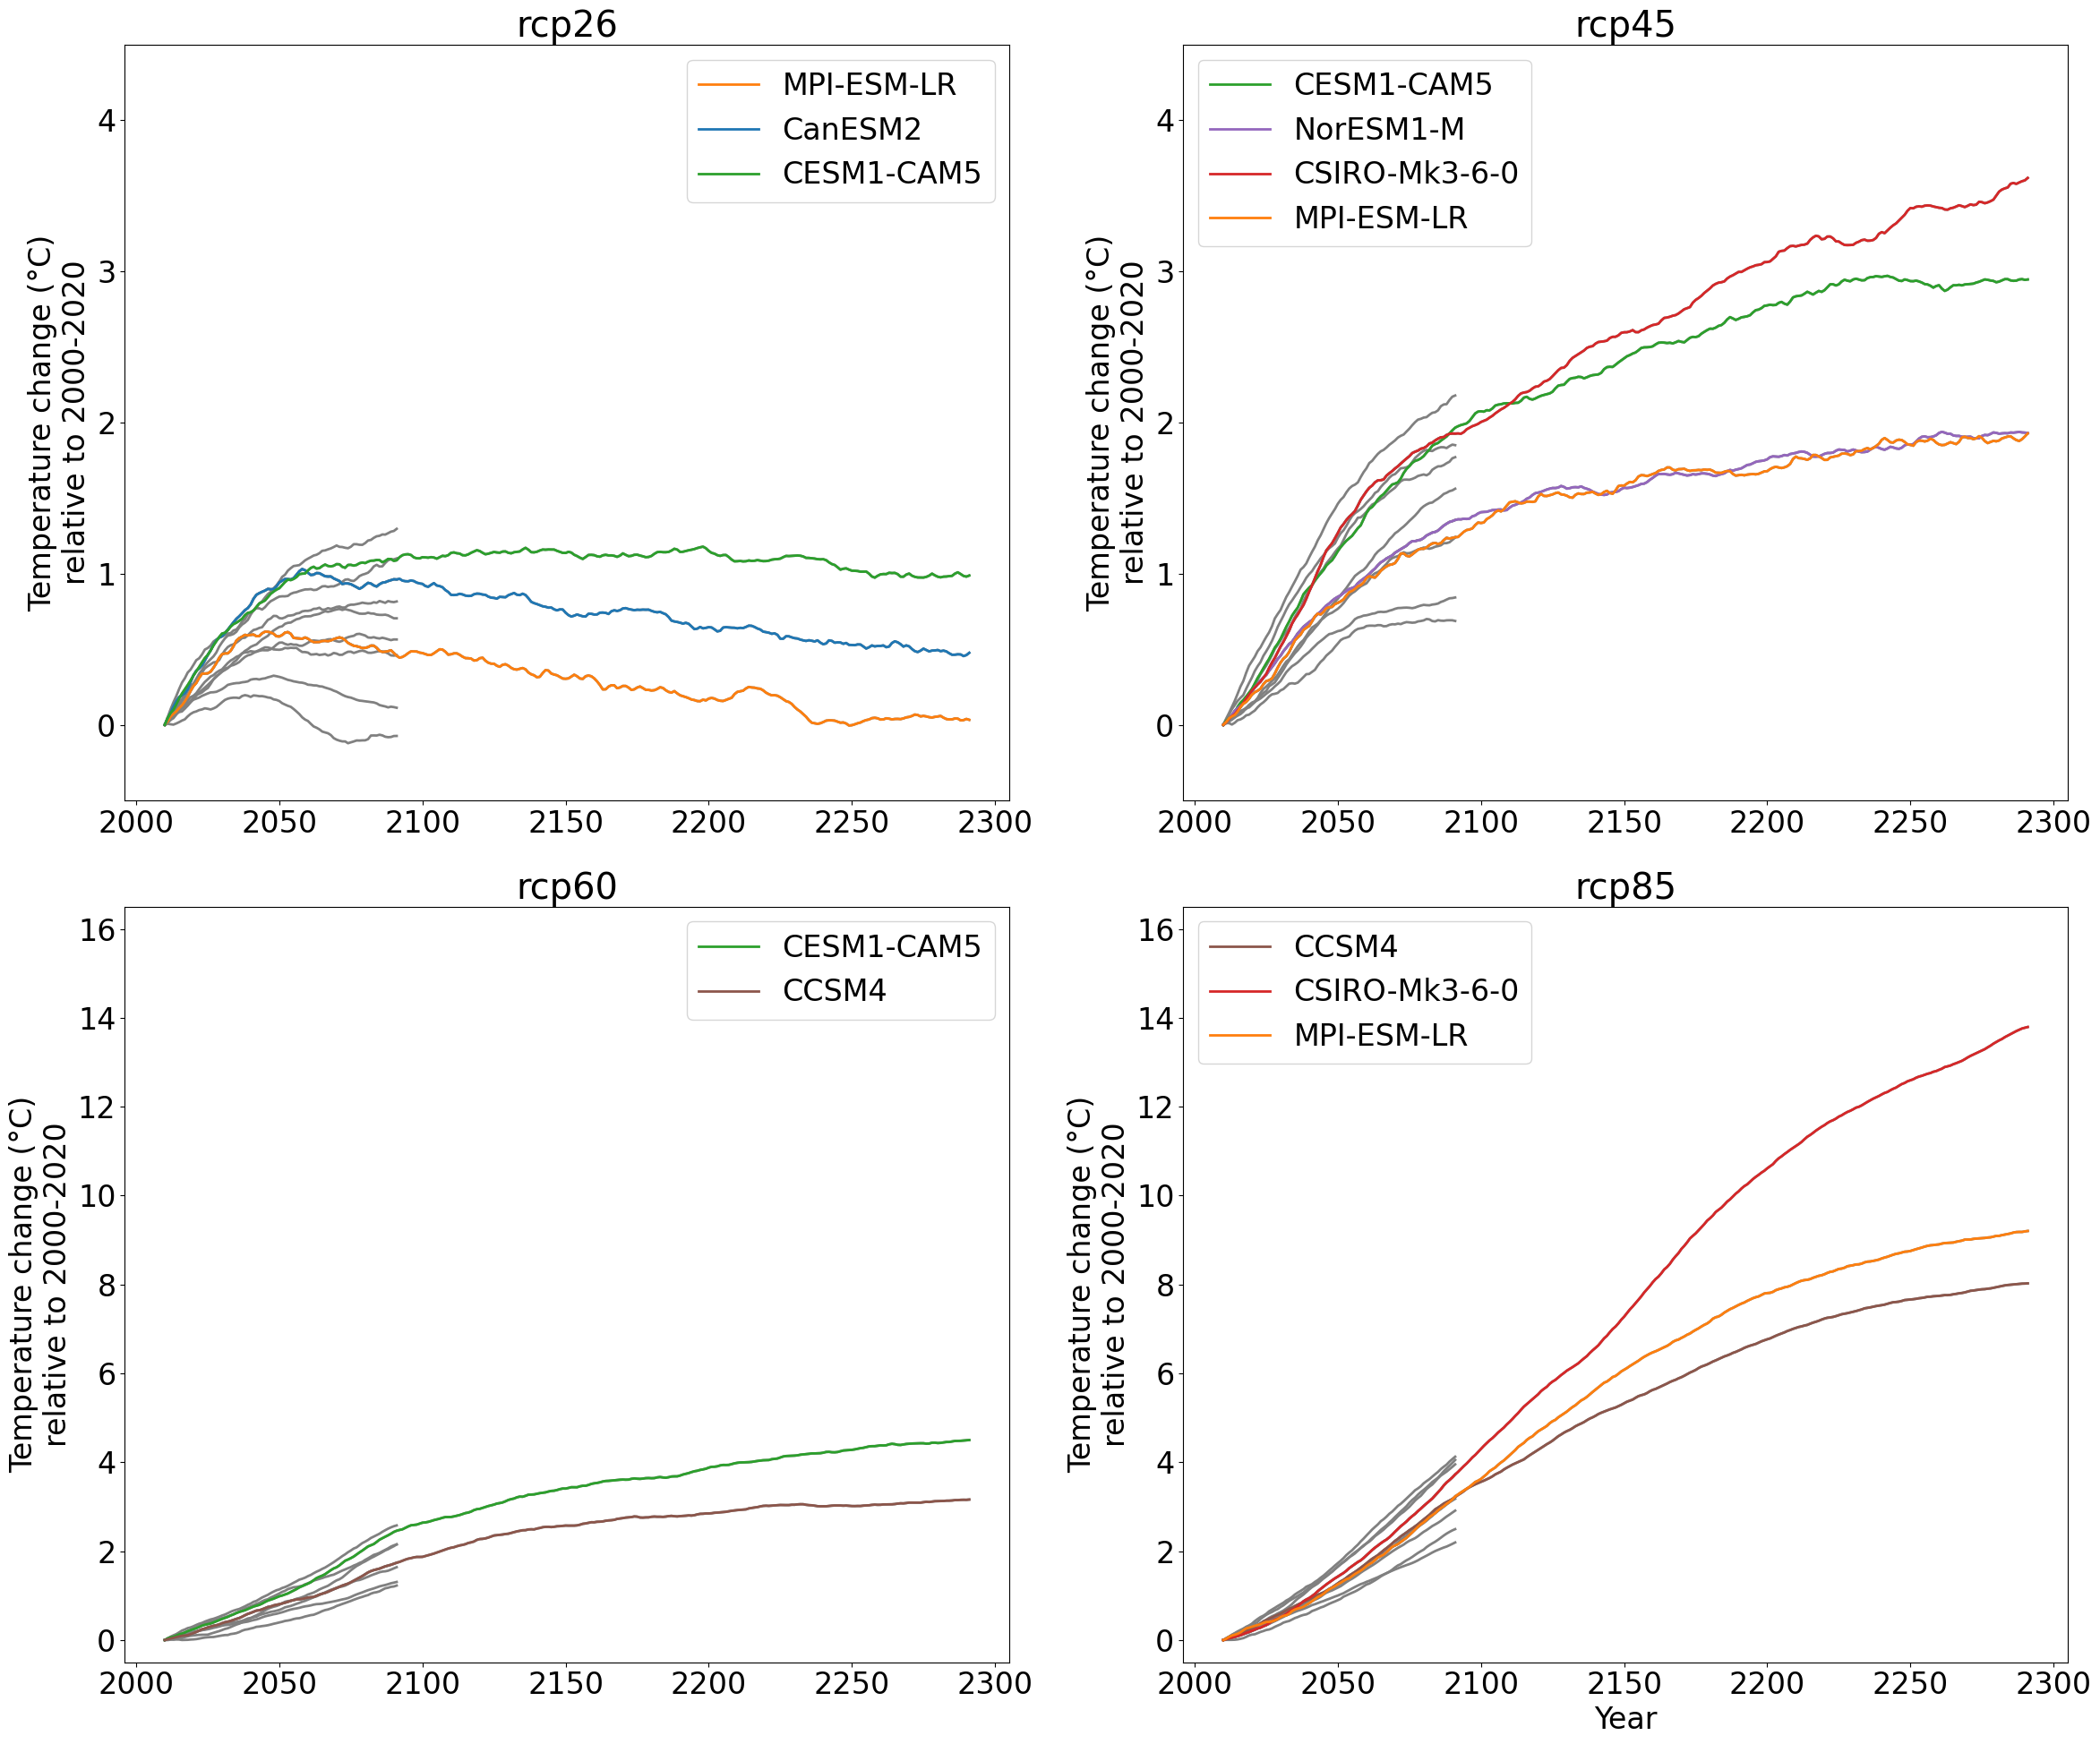

In [14]:
fig,axs = plt.subplots(2,2,figsize=(24,20))
axs = axs.flatten()
plt.rc('font', size=24)
for ax,rcp in  zip(axs,['rcp26', 'rcp45', 'rcp60','rcp85']):
    gcms_cmip5_2300_over = gcms_cmip5.loc[(gcms_cmip5.rcp ==rcp) & (gcms_cmip5['var'] =='tas')]
    for f in gcms_cmip5_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip5_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('2000',
                                                                      '2300')).tas.groupby('time.year').mean()
        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=20, center=True).mean()
        ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
                color= 'grey')
ax.set_xlabel('Year')
     
for ax,rcp in  zip(axs,['rcp26', 'rcp45', 'rcp60','rcp85']):
    gcms_cmip5_2300_over = gcms_cmip5_2300.loc[(gcms_cmip5_2300.rcp==rcp) & (gcms_cmip5_2300['var'] =='tas')]
    for f in gcms_cmip5_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip5_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('2000',
                                                                      '2300')).tas.groupby('time.year').mean()
        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=20, center=True).mean()
        ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
                label=gcms_cmip5_2300_over.loc[f].gcm, 
                color= gcm_c5[gcms_cmip5_2300_over.loc[f].gcm])
    if rcp in ['rcp26', 'rcp45']:
        ax.set_ylim([-0.5,4.5])
    else:
        ax.set_ylim([-0.5,16.5])
    ax.set_ylabel('Temperature change (°C)\nrelative to 2000-2020')
    ax.legend()
    ax.set_title(rcp)
    
ax.set_xlabel('Year')

plt.tight_layout()
#plt.savefig('gcm_global_temp_change_cmip5_ipcc_ar6_def.png')

### Create plots relative to preindustrial levels and showing the lines dependent on 2071-2100 warming 

In [10]:
pd_temp_ch_2100_2300_cmip5 = pd.read_csv('Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip5_gcms_ipcc_ar6_def.csv', index_col=0)
pd_temp_ch_2100_2300_cmip6 = pd.read_csv('Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip6_gcms_ipcc_ar6_def.csv', index_col=0)

In [11]:
pd_temp_ch_2100_2300_both = pd.concat([pd_temp_ch_2100_2300_cmip5, pd_temp_ch_2100_2300_cmip6])

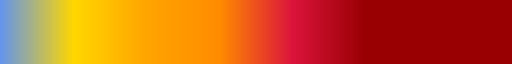

In [12]:
from matplotlib.colors import LinearSegmentedColormap

colors_temp4_l = ['cornflowerblue', 'gold', 'orange', 'darkorange', 'crimson', '#980002', '#980002', '#980002']
cmap_blue_orange = LinearSegmentedColormap.from_list('bins_100',colors_temp4_l, N=1000)
cmap_blue_orange

In [13]:
pd_temp_ch_only_2300_both = pd_temp_ch_2100_2300_both.loc[pd_temp_ch_2100_2300_both['global_temp_ch_2271-2300_preindustrial'].dropna().index]

**Let's scale according to 2300 GCMs**

In [14]:
from sklearn.preprocessing import MinMaxScaler
data_temp = pd_temp_ch_only_2300_both['global_temp_ch_2071-2100_preindustrial'].values.reshape(1,-1).T
scaler = MinMaxScaler()
scaler.fit(data_temp)

MinMaxScaler()

In [15]:
gcms_cmip5_2300 = pd.read_csv('/home/www/oggm/cmip5-ng/all_gcm_list_2300.csv', index_col=0).reset_index(drop=True) 
gcms_cmip5 = pd.read_csv('/home/www/oggm/cmip5-ng/all_gcm_list.csv', index_col=0).reset_index(drop=True)   
# we have used the regular interpolationgcms_cmip5.loc[gcms_cmip5.interpolation == '_g025']
gcms_rcps = []
for ind in gcms_cmip5.loc[gcms_cmip5['var']=='pr'].index:
    gcms_rcps.append(f'{gcms_cmip5.loc[ind].gcm}_{gcms_cmip5.loc[ind].rcp}')
gcm_c5 = {}
for e,gcm in enumerate(['CanESM2', 'MPI-ESM-LR', 'CESM1-CAM5', 'CSIRO-Mk3-6-0',
       'NorESM1-M', 'CCSM4']):
    gcm_c5[gcm] = f'C{e}'

***only show the 2300 GCMs**

ssp126 5
ssp534-over 3
ssp585 5
rcp26 3
rcp45 4
rcp60 2
rcp85 3


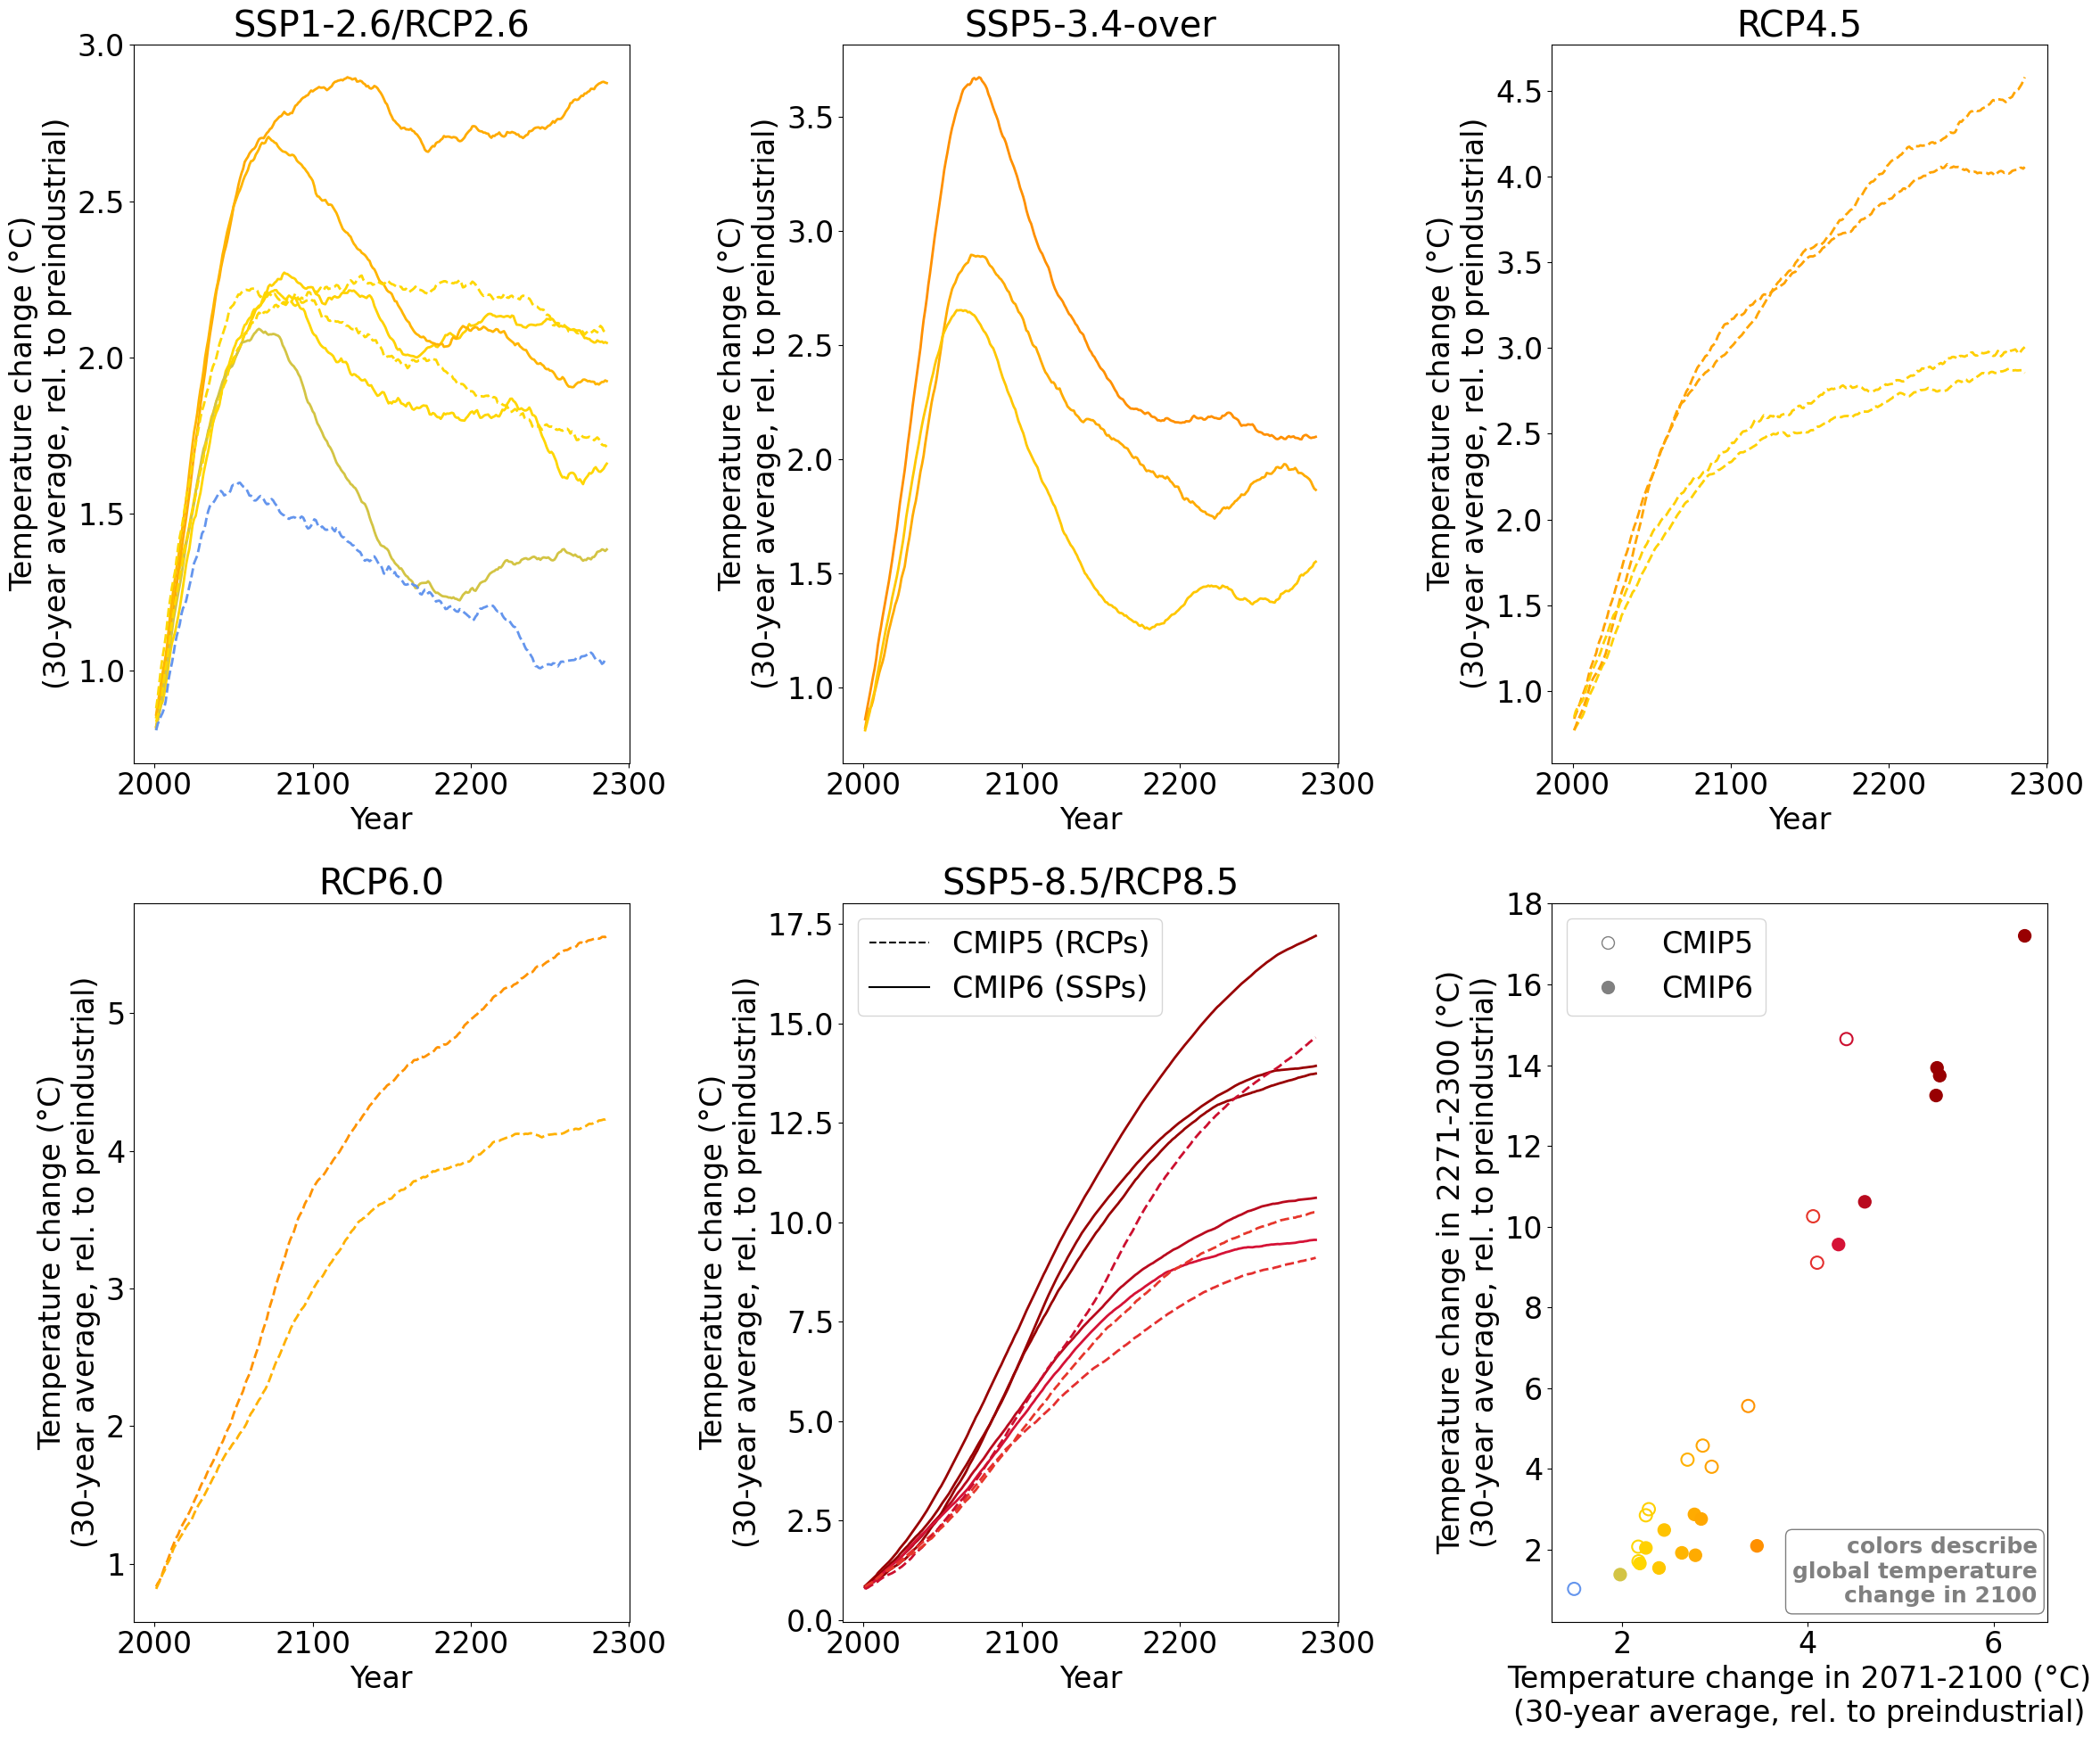

In [24]:
from matplotlib.lines import Line2D
line_cmip5 = Line2D([0], [0], label='CMIP5 (RCPs)', ls='--', color='k')
line_cmip6 = Line2D([0], [0], label='CMIP6 (SSPs)', ls='-', color='k')

fig,axs = plt.subplots(2,3,figsize=(24,20))
axs = axs.flatten()
plt.rc('font', size=24)
for ssp in  ['ssp126','ssp534-over','ssp585']:
    if '26' in ssp:
        ax = axs[0]
        ax.set_title('SSP1-2.6/RCP2.6')
    elif '534-over' in ssp:
        ax = axs[1]
        ax.set_title('SSP5-3.4-over')
    elif '85' in ssp:
        ax = axs[4]
        ax.set_title('SSP5-8.5/RCP8.5')
    gcms_cmip6_sel = gcms_cmip6.loc[gcms_cmip6.y1>2299]
    gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]
    print(ssp, len(gcms_cmip6_2300_over))

    for f in gcms_cmip6_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()
        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=30, center=True).mean()
        color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

        ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + past_warming, lw=2,
                color= color)

for rcp in  ['rcp26', 'rcp45', 'rcp60','rcp85']:
    if '26' in rcp:
        ax = axs[0]
        ax.set_title('SSP1-2.6/RCP2.6')
    elif '45' in rcp:
        ax = axs[2]
        ax.set_title('RCP4.5')
    elif '60' in rcp:
        ax = axs[3]
        ax.set_title('RCP6.0')
    elif '85' in rcp:
        ax = axs[4]
        
    gcms_cmip5_sel = gcms_cmip5.loc[gcms_cmip5.y1>2299]
    gcms_cmip5_2300_over = gcms_cmip5_sel.loc[(gcms_cmip5_sel.rcp ==rcp) & (gcms_cmip5_sel['var'] =='tas')]
    print(rcp, len(gcms_cmip5_2300_over))
    for f in gcms_cmip5_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip5_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1986',
                                                                      '2300')).tas.groupby('time.year').mean()
        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=30, center=True).mean()
        color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

        #ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
        #        color= 'grey')
        ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + past_warming, lw=2, ls = '--',
                color= color)
        
        if ax == axs[-2]:    
            ax.legend(handles=[line_cmip5,line_cmip6])
for ax in axs[:-1]:
    ax.set_ylabel('Temperature change (°C)\n(30-year average, rel. to preindustrial)')
    ax.set_xlabel('Year')

    
ax = axs[-1]
from matplotlib.markers import MarkerStyle
ind_cmip5 = pd_temp_ch_only_2300_both['rcp'].dropna().index

ax.scatter(pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2071-2100_preindustrial'], pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2271-2300_preindustrial'],
            color = cmap_blue_orange(scaler.transform(pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2071-2100_preindustrial'].values.reshape(-1,1))),
            s = 100, cmap =cmap_blue_orange, marker=MarkerStyle('o', fillstyle='none'))#c = color, cmap = )

ind_cmip6 = pd_temp_ch_only_2300_both['ssp'].dropna().index
ax.scatter(pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2071-2100_preindustrial'], pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2271-2300_preindustrial'],
            color = cmap_blue_orange(scaler.transform(pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2071-2100_preindustrial'].values.reshape(-1,1))),
            s = 100, cmap =cmap_blue_orange, marker=MarkerStyle('o', fillstyle='full'))#c = color, cmap = )

points_cmip5 = Line2D([0], [0], label='CMIP5', marker=MarkerStyle('o', fillstyle='none'), markersize=10, lw=0, color='grey',
          fillstyle='none')
points_cmip6 = Line2D([0], [0], label='CMIP6', marker=MarkerStyle('o', fillstyle='full'), markersize=10, lw=0, color='grey',
          )
ax.legend(handles=[points_cmip5,points_cmip6])
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

ax.text(0.98,0.02, 'colors describe\nglobal temperature\nchange in 2100',
                                transform=ax.transAxes,
                                verticalalignment="bottom", bbox=props, horizontalalignment='right',
                                color='grey', alpha=1, fontweight = 'bold', fontsize=18)

#plt.colorbar()
ax.set_xlabel('Temperature change in 2071-2100 (°C)\n(30-year average, rel. to preindustrial)')
ax.set_ylabel('Temperature change in 2271-2300 (°C)\n(30-year average, rel. to preindustrial)')

plt.tight_layout()
plt.savefig('gcm_global_colors_by_temp_change_2300_ipcc_ar6_def.png')
plt.savefig('gcm_global_colors_by_temp_change_2300_ipcc_ar6_def.png')


## Only show the aggregated ones for e.g. [1.5, 2.2, 2.8] +/-0.2

In [114]:
pd_temp_ch_only_2300_both_no_os = pd_temp_ch_only_2300_both.loc[pd_temp_ch_only_2300_both.ssp!='ssp534-over']
temp = 'global_temp_ch_2071-2100_preindustrial'
temp_lev_d = {}
for t in [1.5,2.2,2.8]:
    t1,t2 = t-0.2, t+0.2
    _sel = pd_temp_ch_only_2300_both_no_os.loc[(pd_temp_ch_only_2300_both_no_os[temp]>=t1) & (pd_temp_ch_only_2300_both_no_os[temp]<=t2)]
    print(t, _sel[temp].median(), _sel[temp].mean(), _sel.index.values, len(_sel.index.values))
    _sel.index
    temp_lev_d[str(t)] = list(_sel.index)

# now select the timeseries ... 
gcms_cmip6 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)   
gcms_cmip5 = pd.read_csv('/home/www/oggm/cmip5-ng/all_gcm_list.csv', index_col=0).reset_index(drop=True)   

gcms_cmip6.index = gcms_cmip6.gcm.str.upper()+'_'+gcms_cmip6.ssp
gcms_cmip5.index = gcms_cmip5.gcm.str.upper()+'_'+gcms_cmip5.rcp
gcms_cmip = pd.concat([gcms_cmip6,gcms_cmip5])
gcms_cmip = gcms_cmip.loc[gcms_cmip.y1>=2299]

1.5 1.487504187860568 1.487504187860568 ['MPI-ESM-LR_rcp26'] 1
2.2 2.226892758161116 2.2268995837653662 ['MPI-ESM-LR_rcp45' 'NORESM1-M_rcp45' 'CANESM2_rcp26' 'CESM1-CAM5_rcp26'
 'ACCESS-ESM1-5_ssp126' 'IPSL-CM6A-LR_ssp126'] 6
2.8 2.781734634600584 2.794558776816907 ['CSIRO-MK3-6-0_rcp45' 'CESM1-CAM5_rcp45' 'CCSM4_rcp60'
 'ACCESS-CM2_ssp126' 'CANESM5_ssp126'] 5


In [98]:
min_scaler, max_scaler = (1.487504187860568, 4.4166525061210695)
scaler_below45deg = MinMaxScaler()
scaler_below45deg.fit(np.array([min_scaler, max_scaler]).reshape(-1, 1))

colors_icci_l3 = ['#70B8FF', '#FABB00', '#F25100', '#D42300', '#B3001E', '#800040', '#550066', '#2B084D']
cmap_icci_3 = LinearSegmentedColormap.from_list('bins_100', colors_icci_l3, N=10000)

1.5 1
2.2 6
2.8 5


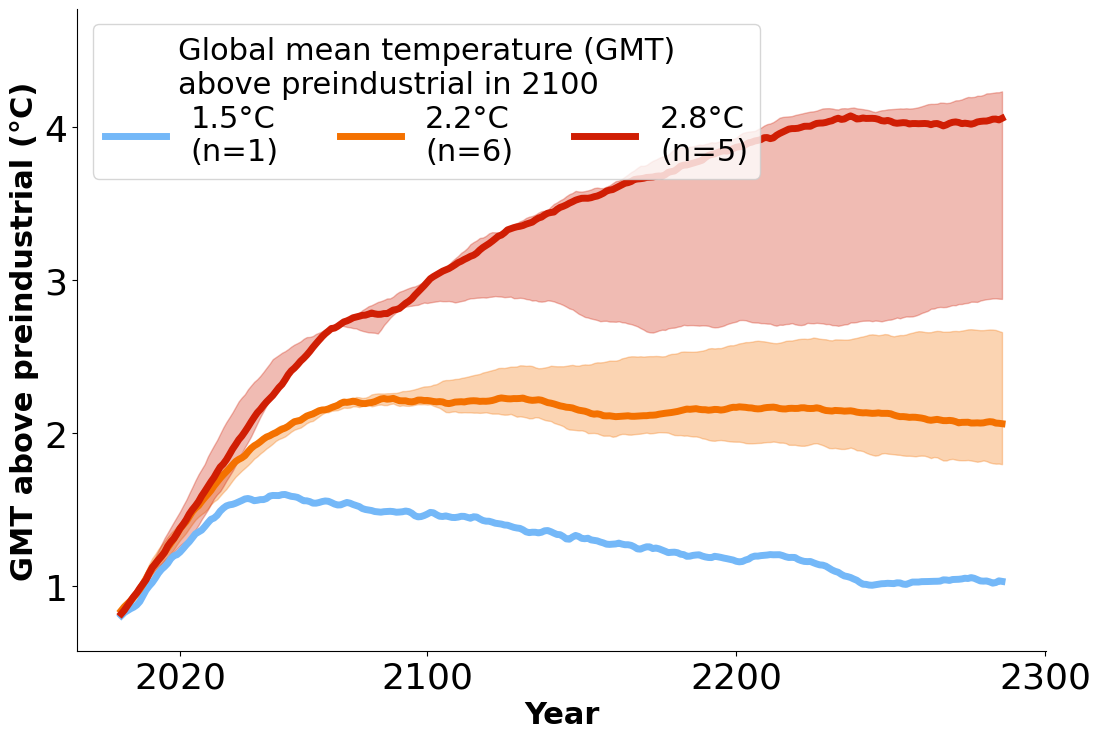

In [126]:
plt.rc('font', size=26)
fig, axs = plt.subplots(1,1, figsize=(12.5,25/3)) 

ax = axs
for t in [1.5,2.2,2.8]:
    
    _sel_gcms_cmip = gcms_cmip.loc[temp_lev_d[str(t)]]
    _sel_gcms_cmip=_sel_gcms_cmip.loc[_sel_gcms_cmip['var'] =='tas']
    print(t, len(_sel_gcms_cmip))
    pd_global_dtas_all = pd.DataFrame(index=np.arange(2000,2301))
    for f in _sel_gcms_cmip.index:
        dtas_annual = xr.open_dataset(_sel_gcms_cmip.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()
    
        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()
        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming
    
        # get the global means for every month:
        global_dtas_ch = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=30, center=True).mean() - avg_1986_2005 + past_warming
        #color= cmap(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()
        # we don't want to show the individual lines
        color= cmap_icci_3(scaler_below45deg.transform(np.float64(t).reshape(-1,1))).flatten()
        ax.plot(global_dtas_ch.year, global_dtas_ch.values,
            lw=0, color=color, label=f'{t}°C' )
        pd_global_dtas_all[f] = global_dtas_ch.sel(year=slice(2000,2300)).values
    color= cmap_icci_3(scaler_below45deg.transform(np.float64(t).reshape(-1,1))).flatten()
    n=len(pd_global_dtas_all.columns)
    ax.plot(pd_global_dtas_all.index, pd_global_dtas_all.median(axis=1),
            lw=5, color=color, label=f'{t}°C\n(n={n})' )
    ax.fill_between(pd_global_dtas_all.index, 
                pd_global_dtas_all.quantile(0.25, axis=1), pd_global_dtas_all.quantile(0.75, axis=1), 
                alpha =0.3, color=color)
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel('GMT above preindustrial (°C)',fontweight = 'bold', fontsize=22)
plt.legend([handles[1], handles[8], handles[14]], 
           [labels[1], labels[8], labels[14]],
           title='Global mean temperature (GMT)\nabove preindustrial in 2100',
           labelspacing=0.15, ncol=3, 
                 title_fontsize=22, fontsize=22)
ax.set_xticks([2020,2100,2200,2300],[2020,2100,2200,2300])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Year',  fontweight = 'bold', fontsize=22)
plt.savefig('icci_2024_glaciers_climate_scenario_selection.png')
plt.savefig('icci_2024_glaciers_climate_scenario_selection.pdf')
plt.savefig('icci_2024_glaciers_climate_scenario_selection.svg')

**Show until 2100 and until 2300**

ssp126 17
ssp534-over 4
ssp585 19
rcp26 13
rcp45 14
rcp60 9
rcp85 13


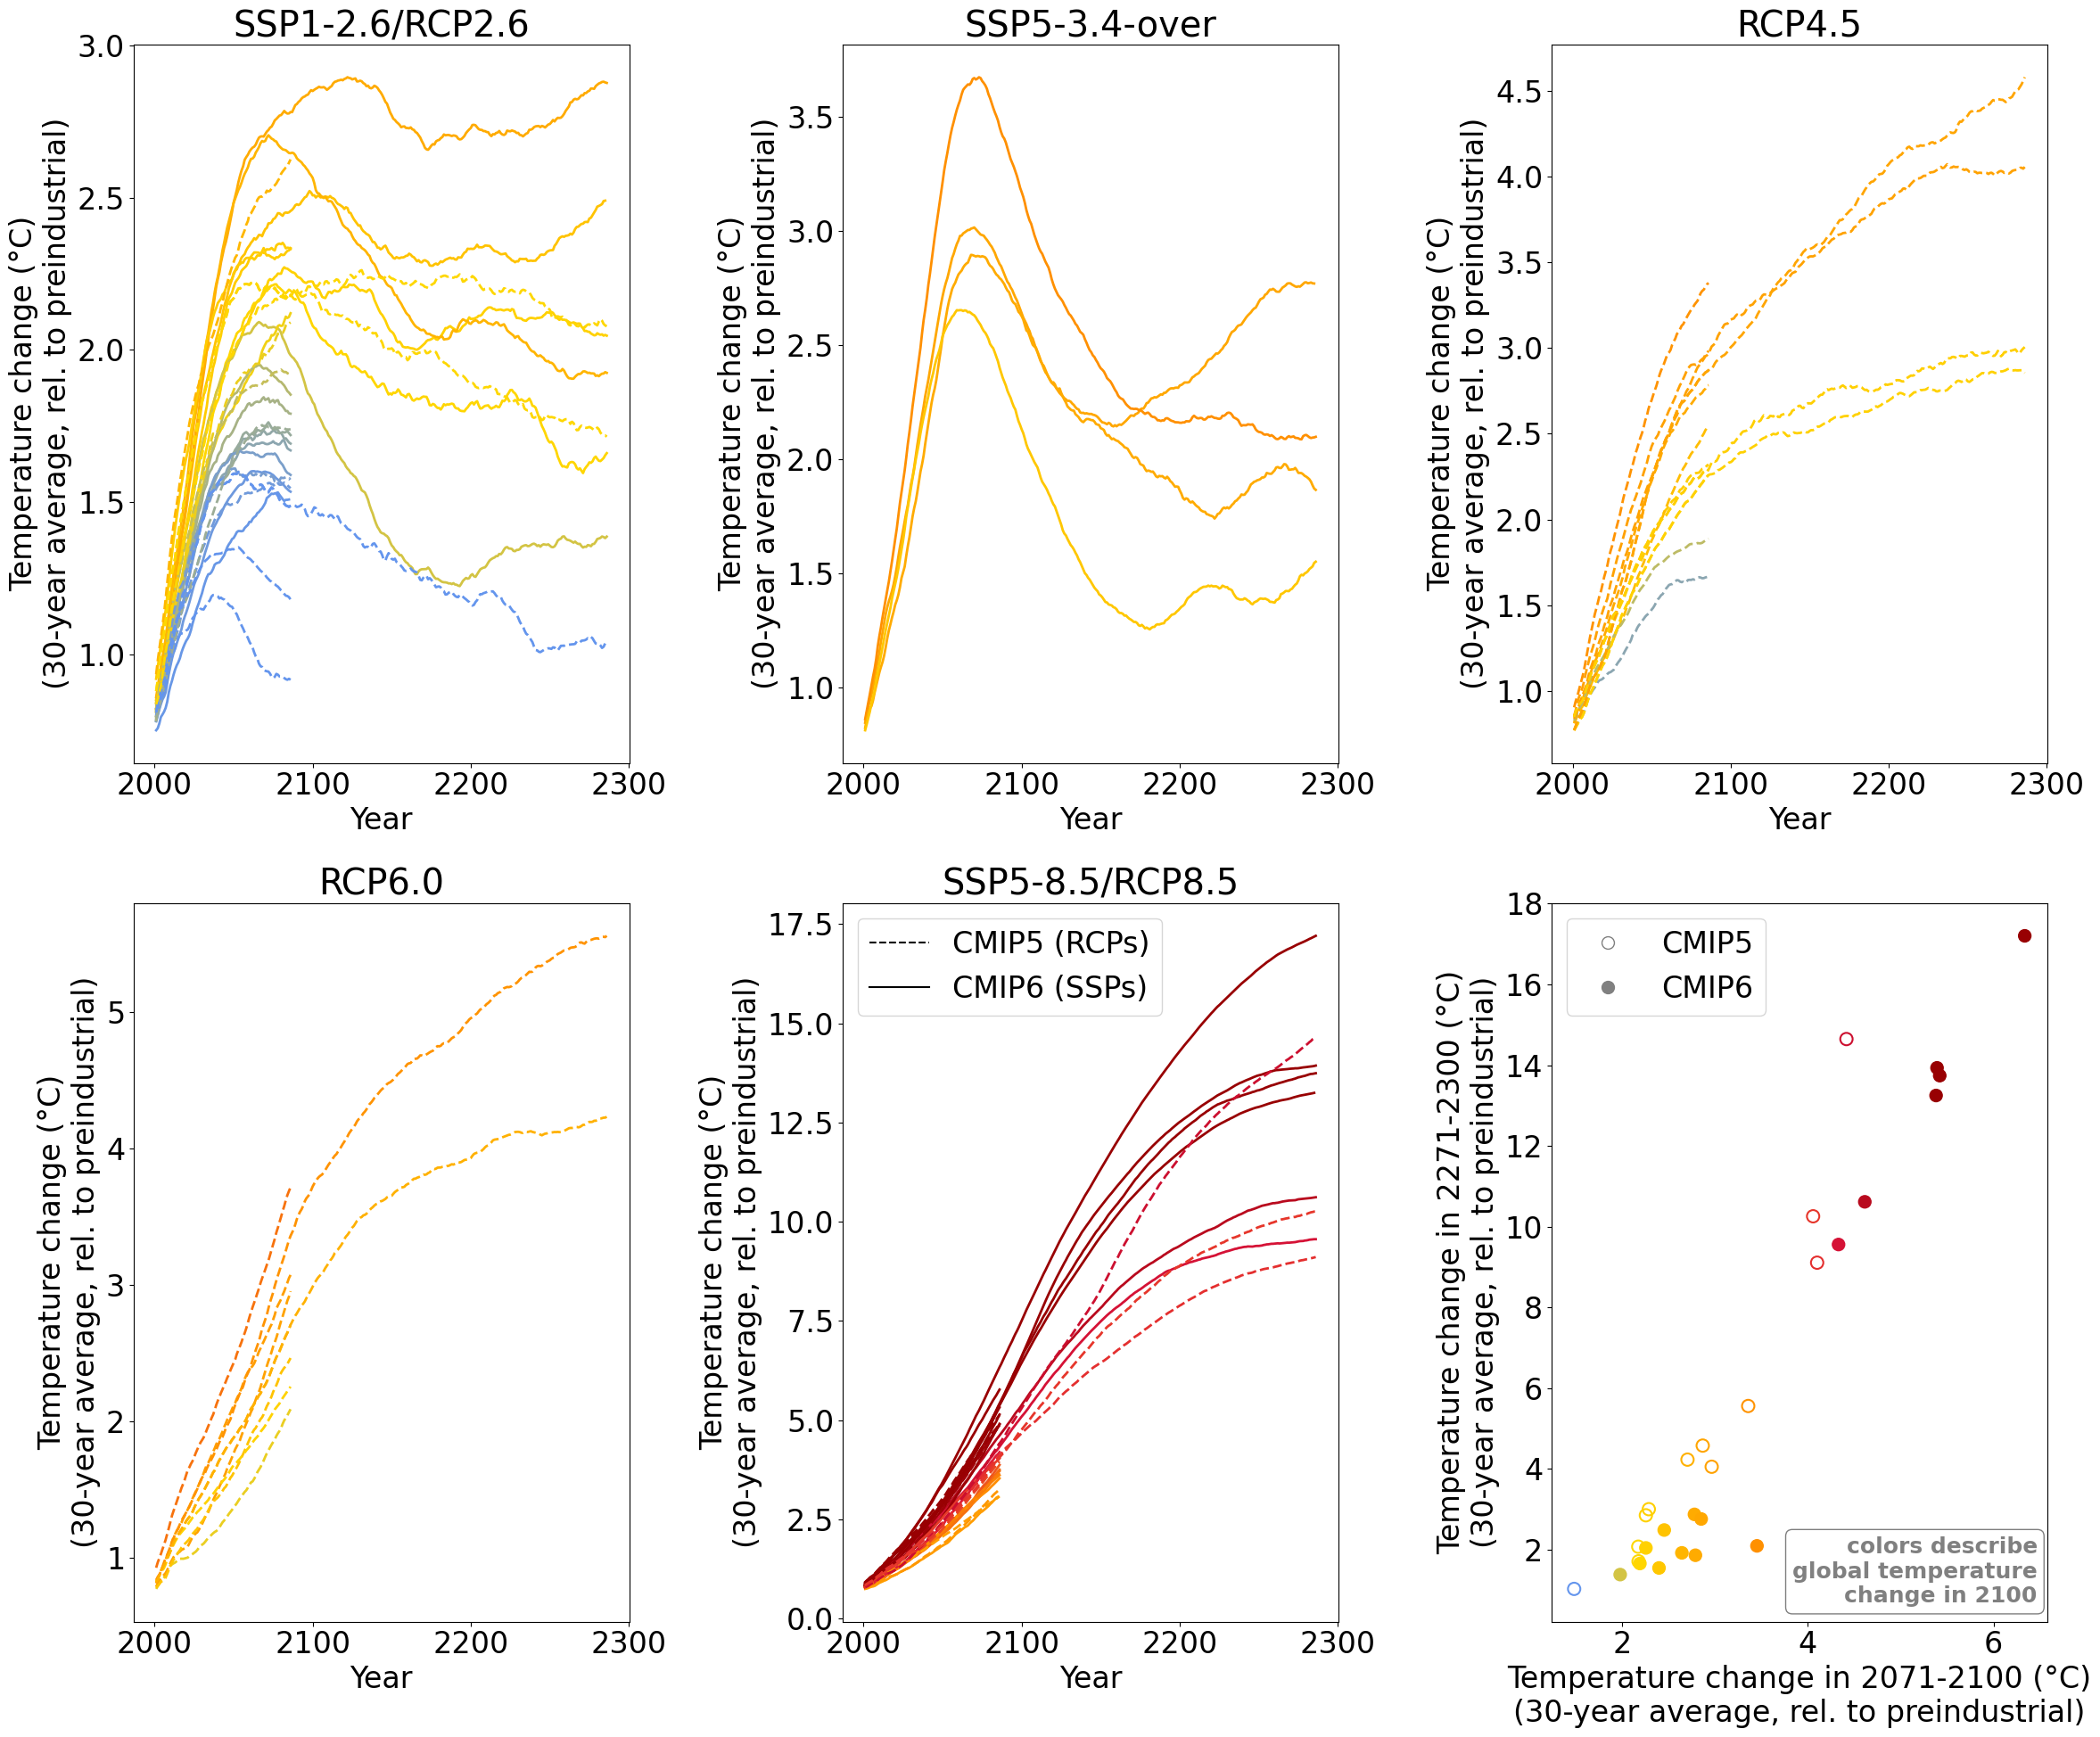

In [22]:
from matplotlib.lines import Line2D
line_cmip5 = Line2D([0], [0], label='CMIP5 (RCPs)', ls='--', color='k')
line_cmip6 = Line2D([0], [0], label='CMIP6 (SSPs)', ls='-', color='k')

fig,axs = plt.subplots(2,3,figsize=(24,20))
axs = axs.flatten()
plt.rc('font', size=24)
for ssp in  ['ssp126','ssp534-over','ssp585']:
    if '26' in ssp:
        ax = axs[0]
        ax.set_title('SSP1-2.6/RCP2.6')
    elif '534-over' in ssp:
        ax = axs[1]
        ax.set_title('SSP5-3.4-over')
    elif '85' in ssp:
        ax = axs[4]
        ax.set_title('SSP5-8.5/RCP8.5')
    gcms_cmip6_sel = gcms_cmip6#.loc[gcms_cmip6.y1>2299]
    gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]
    print(ssp, len(gcms_cmip6_2300_over))

    for f in gcms_cmip6_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()
        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=30, center=True).mean()
        color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

        ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + past_warming, lw=2,
                color= color)

for rcp in  ['rcp26', 'rcp45', 'rcp60','rcp85']:
    if '26' in rcp:
        ax = axs[0]
        ax.set_title('SSP1-2.6/RCP2.6')
    elif '45' in rcp:
        ax = axs[2]
        ax.set_title('RCP4.5')
    elif '60' in rcp:
        ax = axs[3]
        ax.set_title('RCP6.0')
    elif '85' in rcp:
        ax = axs[4]
        
    gcms_cmip5_sel = gcms_cmip5#.loc[gcms_cmip5.y1>2299]
    gcms_cmip5_2300_over = gcms_cmip5_sel.loc[(gcms_cmip5_sel.rcp ==rcp) & (gcms_cmip5_sel['var'] =='tas')]
    print(rcp, len(gcms_cmip5_2300_over))
    for f in gcms_cmip5_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip5_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1986',
                                                                      '2300')).tas.groupby('time.year').mean()
        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=30, center=True).mean()
        color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

        #ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
        #        color= 'grey')
        ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + past_warming, lw=2, ls = '--',
                color= color)
        
        if ax == axs[-2]:    
            ax.legend(handles=[line_cmip5,line_cmip6])
for ax in axs[:-1]:
    ax.set_ylabel('Temperature change (°C)\n(30-year average, rel. to preindustrial)')
    ax.set_xlabel('Year')

    
ax = axs[-1]
from matplotlib.markers import MarkerStyle
ind_cmip5 = pd_temp_ch_only_2300_both['rcp'].dropna().index

ax.scatter(pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2071-2100_preindustrial'], pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2271-2300_preindustrial'],
            color = cmap_blue_orange(scaler.transform(pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2071-2100_preindustrial'].values.reshape(-1,1))),
            s = 100, cmap =cmap_blue_orange, marker=MarkerStyle('o', fillstyle='none'))#c = color, cmap = )

ind_cmip6 = pd_temp_ch_only_2300_both['ssp'].dropna().index
ax.scatter(pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2071-2100_preindustrial'], pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2271-2300_preindustrial'],
            color = cmap_blue_orange(scaler.transform(pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2071-2100_preindustrial'].values.reshape(-1,1))),
            s = 100, cmap =cmap_blue_orange, marker=MarkerStyle('o', fillstyle='full'))#c = color, cmap = )

points_cmip5 = Line2D([0], [0], label='CMIP5', marker=MarkerStyle('o', fillstyle='none'), markersize=10, lw=0, color='grey',
          fillstyle='none')
points_cmip6 = Line2D([0], [0], label='CMIP6', marker=MarkerStyle('o', fillstyle='full'), markersize=10, lw=0, color='grey',
          fillstyle='none')
ax.legend(handles=[points_cmip5,points_cmip6])
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

ax.text(0.98,0.02, 'colors describe\nglobal temperature\nchange in 2100',
                                transform=ax.transAxes,
                                verticalalignment="bottom", bbox=props, horizontalalignment='right',
                                color='grey', alpha=1, fontweight = 'bold', fontsize=18)

#plt.colorbar()
ax.set_xlabel('Temperature change in 2071-2100 (°C)\n(30-year average, rel. to preindustrial)')
ax.set_ylabel('Temperature change in 2271-2300 (°C)\n(30-year average, rel. to preindustrial)')

plt.tight_layout()
plt.savefig('gcm_global_colors_by_temp_change_2100_2300_ipcc_ar6_def.png')
plt.savefig('gcm_global_colors_by_temp_change_2100_2300_ipcc_ar6_def.png')


**Only show those until 2100 (but at the moment it uses the same cmap)**

In [7]:
gcms_cmip6

index                                               path       folder  \
0        0  /home/www/oggm/cmip6/GCM/CESM2-WACCM/CESM2-WAC...  CESM2-WACCM   
1        2  /home/www/oggm/cmip6/GCM/CESM2-WACCM/CESM2-WAC...  CESM2-WACCM   
2        7  /home/www/oggm/cmip6/GCM/CESM2-WACCM/CESM2-WAC...  CESM2-WACCM   
3        8  /home/www/oggm/cmip6/GCM/CESM2-WACCM/CESM2-WAC...  CESM2-WACCM   
4        9  /home/www/oggm/cmip6/GCM/CESM2-WACCM/CESM2-WAC...  CESM2-WACCM   
..     ...                                                ...          ...   
141    434  /home/www/oggm/cmip6/GCM/FGOALS-f3-L/FGOALS-f3...  FGOALS-f3-L   
142    435  /home/www/oggm/cmip6/GCM/FGOALS-f3-L/FGOALS-f3...  FGOALS-f3-L   
143    437  /home/www/oggm/cmip6/GCM/FGOALS-f3-L/FGOALS-f3...  FGOALS-f3-L   
144    438  /home/www/oggm/cmip6/GCM/FGOALS-f3-L/FGOALS-f3...  FGOALS-f3-L   
145    440  /home/www/oggm/cmip6/GCM/FGOALS-f3-L/FGOALS-f3...  FGOALS-f3-L   

                                  fname  valid          gcm     ssp       rea  \
0     CESM2-WACCM_ssp126_r1i1p1f1_pr.nc   True  CESM2-WACCM  ssp126  r1i1p1f1   
1    CESM2-WACCM_ssp585_r1i1p1f1_tas.nc   True  CESM2-WACCM  ssp585  r1i1p1f1   
2     CESM2-WACCM_ssp370_r1i1p1f1_pr.nc   True  CESM2-WACCM  ssp370  r1i1p1f1   
3    CESM2-WACCM_ssp370_r1i1p1f1_tas.nc   True  CESM2-WACCM  ssp370  r1i1p1f1   
4     CESM2-WACCM_ssp585_r1i1p1f1_pr.nc   True  CESM2-WACCM  ssp585  r1i1p1f1   
..                                  ...    ...          ...     ...       ...   
141   FGOALS-f3-L_ssp245_r1i1p1f1_pr.nc   True  FGOALS-f3-L  ssp245  r1i1p1f1   
142   FGOALS-f3-L_ssp585_r1i1p1f1_pr.nc   True  FGOALS-f3-L  ssp585  r1i1p1f1   
143   FGOALS-f3-L_ssp370_r1i1p1f1_pr.nc   True  FGOALS-f3-L  ssp370  r1i1p1f1   
144   FGOALS-f3-L_ssp126_r1i1p1f1_pr.nc   True  FGOALS-f3-L  ssp126  r1i1p1f1   
145  FGOALS-f3-L_ssp245_r1i1p1f1_tas.nc   True  FGOALS-f3-L  ssp245  r1i1p1f1   

     var    y0    y1  resolution  
0     pr  1850  2299        1.25  
1    tas  1850  2299        1.25  
2     pr  1850  2100        1.25  
3    tas  1850  2100        1.25  
4     pr  1850  2299        1.25  
..   ...   ...   ...         ...  
141   pr  1850  2100        1.25  
142   pr  1850  2100        1.25  
143   pr  1850  2100        1.25  
144   pr  1850  2100        1.25  
145  tas  1850  2100        1.25  

[146 rows x 12 columns]

In [ ]:

plt.rc('font', size=24)
for ssp in  ['ssp126', 'ssp585', 'ssp370', 'ssp534-over', 'ssp245', 'ssp119', 'ssp434', 'ssp460']:

    gcms_cmip6_sel = gcms_cmip6#.loc[gcms_cmip6.y1<=2100]
    gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]
    print(ssp, len(gcms_cmip6_2300_over))

    for f in gcms_cmip6_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1986','2100')).tas.groupby('time.year').mean()

        ['ssp126', 'ssp585', 'ssp370', 'ssp534-over', 'ssp245', 'ssp119',
       'ssp434', 'ssp460']weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()
        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=30, center=True).mean()
        
        _global_dtas = global_dtas.sel(year=slice(2000,2100))
        oversh = _global_dtas.max() - _global_dtas.dropna(dim='year').isel(year=-1)
        if oversh > 0:
            print(ssp, gcms_cmip6_2300_over.loc[f]['gcm'], oversh.values)
for rcp in  ['rcp26', 'rcp45', 'rcp60','rcp85']:

        
    gcms_cmip5_sel = gcms_cmip5#.loc[gcms_cmip5.y1<=2100]
    gcms_cmip5_2300_over = gcms_cmip5_sel.loc[(gcms_cmip5_sel.rcp ==rcp) & (gcms_cmip5_sel['var'] =='tas')]
    print(rcp, len(gcms_cmip5_2300_over))
    for f in gcms_cmip5_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip5_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1986',
                                                                      '2100')).tas.groupby('time.year').mean()
        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=30, center=True).mean()
            
        _global_dtas = global_dtas.sel(year=slice(2000,2100))
        oversh = _global_dtas.max() - _global_dtas.dropna(dim='year').isel(year=-1)
        if oversh > 0:
            print(rcp, gcms_cmip5_2300_over.loc[f]['gcm'], oversh.values)



ssp126 17
ssp126 MPI-ESM1-2-HR 0.033057801702341294
ssp126 GFDL-ESM4 0.04246980951864998
ssp126 NorESM2-MM 0.042000325053891174
ssp126 ACCESS-ESM1-5 0.011990012060834943
ssp126 ACCESS-CM2 0.003556188830998508
ssp126 INM-CM4-8 0.06729700910631209
ssp126 CanESM5 0.05889031987805993
ssp126 IPSL-CM6A-LR 0.020782470703125
ssp126 INM-CM5-0 0.07906850751749062
ssp126 MRI-ESM2-0 0.10884608887818104
ssp126 EC-Earth3 0.020371830721842343
ssp126 CAMS-CSM1-0 0.023259036998979354
ssp126 BCC-CSM2-MR 0.0967933333456017
ssp126 FGOALS-f3-L 0.05393684409131083
ssp585 19
ssp370 13
ssp534-over 4
ssp534-over CESM2-WACCM 0.1599635226916689
ssp534-over CanESM5 0.21702963605770265
ssp534-over IPSL-CM6A-LR 0.10186767578125
ssp534-over MRI-ESM2-0 0.2514515345546897
ssp245 14
ssp119 4
ssp119 GFDL-ESM4 0.25519054204806935
ssp119 MRI-ESM2-0 0.2707068945693436
ssp119 EC-Earth3-Veg 0.04041266884388506
ssp119 CAMS-CSM1-0 0.17428272526302635
ssp434 1
ssp460 1
rcp26 13
rcp26 IPSL-CM5A-LR 0.014790301030188857
rcp26 NorE

ssp126 17
ssp126 MPI-ESM1-2-HR 0.033057801702341294
ssp126 GFDL-ESM4 0.04246980951864998
ssp126 NorESM2-MM 0.042000325053891174
ssp126 ACCESS-ESM1-5 0.011990012060834943
ssp126 ACCESS-CM2 0.003556188830998508
ssp126 INM-CM4-8 0.06729700910631209
ssp126 CanESM5 0.05889031987805993
ssp126 IPSL-CM6A-LR 0.020782470703125
ssp126 INM-CM5-0 0.07906850751749062
ssp126 MRI-ESM2-0 0.10884608887818104
ssp126 EC-Earth3 0.020371830721842343
ssp126 CAMS-CSM1-0 0.023259036998979354
ssp126 BCC-CSM2-MR 0.0967933333456017
ssp126 FGOALS-f3-L 0.05393684409131083
ssp534-over 4
ssp534-over CESM2-WACCM 0.1599635226916689
ssp534-over CanESM5 0.21702963605770265
ssp534-over IPSL-CM6A-LR 0.10186767578125
ssp534-over MRI-ESM2-0 0.2514515345546897
ssp585 19
rcp26 13
ssp585 IPSL-CM5A-LR 0.014790301030188857
ssp585 NorESM1-M 0.018731675115759572
ssp585 MPI-ESM-LR 0.11235371765576474
ssp585 CCSM4 0.030817343504509154
ssp585 GFDL-ESM2G 0.27864972944450983
ssp585 CNRM-CM5 0.013373462825768456
ssp585 CanESM2 0.04093419

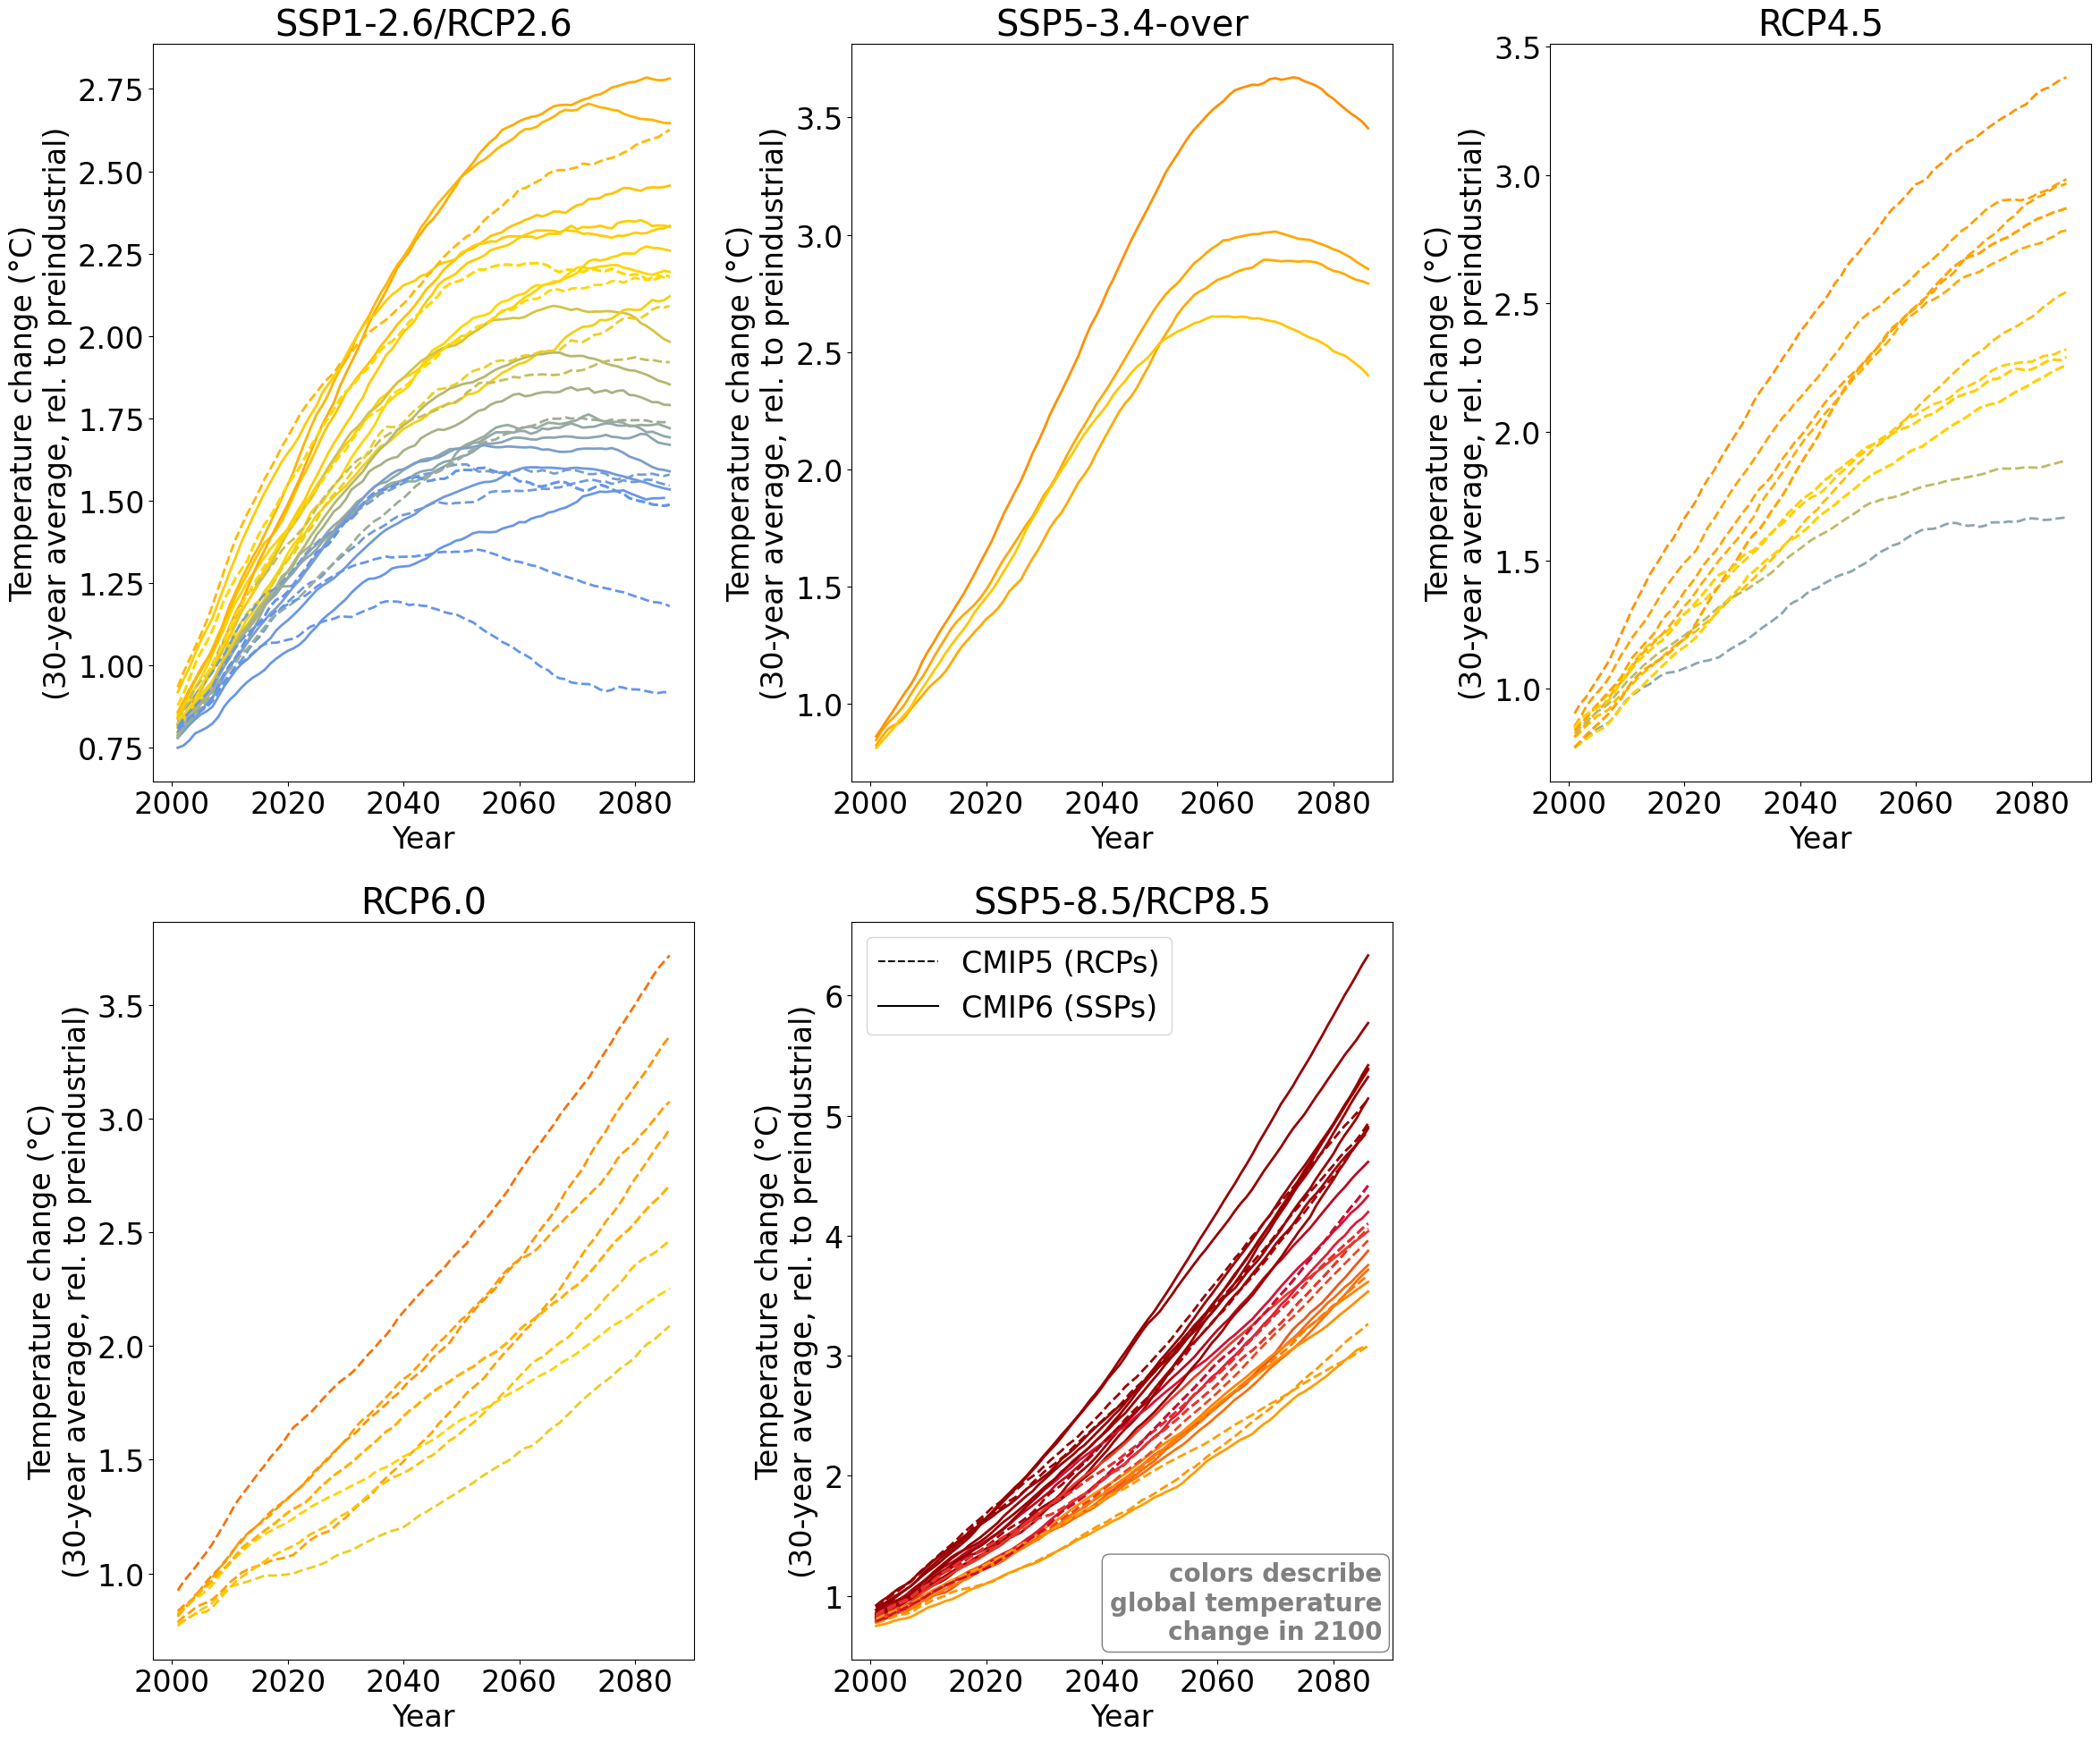

In [29]:
from matplotlib.lines import Line2D
line_cmip5 = Line2D([0], [0], label='CMIP5 (RCPs)', ls='--', color='k')
line_cmip6 = Line2D([0], [0], label='CMIP6 (SSPs)', ls='-', color='k')

fig,axs = plt.subplots(2,3,figsize=(24,20))
axs = axs.flatten()
plt.rc('font', size=24)
for ssp in  ['ssp126','ssp534-over','ssp585']:
    if '26' in ssp:
        ax = axs[0]
        ax.set_title('SSP1-2.6/RCP2.6')
    elif '534-over' in ssp:
        ax = axs[1]
        ax.set_title('SSP5-3.4-over')
    elif '85' in ssp:
        ax = axs[4]
        ax.set_title('SSP5-8.5/RCP8.5')
    gcms_cmip6_sel = gcms_cmip6#.loc[gcms_cmip6.y1<=2100]
    gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]
    print(ssp, len(gcms_cmip6_2300_over))

    for f in gcms_cmip6_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1986','2100')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()
        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=30, center=True).mean()
        color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

        ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + past_warming, lw=2,
                color= color)
        
        _global_dtas = global_dtas.sel(year=slice(2000,2100))
        oversh = _global_dtas.max() - _global_dtas.dropna(dim='year').isel(year=-1)
        if oversh > 0:
            print(ssp, gcms_cmip6_2300_over.loc[f]['gcm'], oversh.values)
for rcp in  ['rcp26', 'rcp45', 'rcp60','rcp85']:
    if '26' in rcp:
        ax = axs[0]
        ax.set_title('SSP1-2.6/RCP2.6')
    elif '45' in rcp:
        ax = axs[2]
        ax.set_title('RCP4.5')
    elif '60' in rcp:
        ax = axs[3]
        ax.set_title('RCP6.0')
    elif '85' in rcp:
        ax = axs[4]
        
    gcms_cmip5_sel = gcms_cmip5#.loc[gcms_cmip5.y1<=2100]
    gcms_cmip5_2300_over = gcms_cmip5_sel.loc[(gcms_cmip5_sel.rcp ==rcp) & (gcms_cmip5_sel['var'] =='tas')]
    print(rcp, len(gcms_cmip5_2300_over))
    for f in gcms_cmip5_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip5_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1986',
                                                                      '2100')).tas.groupby('time.year').mean()
        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=30, center=True).mean()
        color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

        #ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
        #        color= 'grey')
        ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + past_warming, lw=2, ls = '--',
                color= color)
        
        if ax == axs[-2]:    
            ax.legend(handles=[line_cmip5,line_cmip6])
            
        _global_dtas = global_dtas.sel(year=slice(2000,2100))
        oversh = _global_dtas.max() - _global_dtas.dropna(dim='year').isel(year=-1)
        if oversh > 0:
            print(rcp, gcms_cmip5_2300_over.loc[f]['gcm'], oversh.values)
for ax in axs[:-1]:
    ax.set_ylabel('Temperature change (°C)\n(30-year average, rel. to preindustrial)')
    ax.set_xlabel('Year')

    
ax = axs[-2]
from matplotlib.markers import MarkerStyle
#ind_cmip5 = pd_temp_ch_only_2300_both['rcp'].dropna().index
#ax.scatter(pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2071-2100_preindustrial'], pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2271-2300_preindustrial'],
#            color = cmap_blue_orange(scaler.transform(pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2071-2100_preindustrial'].values.reshape(-1,1))),
#            s = 100, cmap =cmap_blue_orange, marker=MarkerStyle('o', fillstyle='none'))#c = color, cmap = )

#ind_cmip6 = pd_temp_ch_only_2300_both['ssp'].dropna().index
#ax.scatter(pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2071-2100_preindustrial'], pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2271-2300_preindustrial'],
#            color = cmap_blue_orange(scaler.transform(pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2071-2100_preindustrial'].values.reshape(-1,1))),
#            s = 100, cmap =cmap_blue_orange, marker=MarkerStyle('o', fillstyle='full'))#c = color, cmap = )

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

ax.text(0.98,0.02, 'colors describe\nglobal temperature\nchange in 2100',
                                transform=ax.transAxes,
                                verticalalignment="bottom", bbox=props, horizontalalignment='right',
                                color='grey', alpha=1, fontweight = 'bold', fontsize=20)

axs[-1].remove()

plt.tight_layout()
plt.savefig('gcm_global_colors_by_temp_change_2100_ipcc_ar6_def.png')
plt.savefig('gcm_global_colors_by_temp_change_2100_ipcc_ar6_def.png')


**TODO: extract local RGI glacier region climate**
- problem so far, somehow, I don't manage to define correctly the lon_bins
- another issue: every GCM has a different interpolation ... 

In [10]:
import oggm
frgi = oggm.utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
odf = pd.read_hdf(frgi, index_col=0)


**Here is just to extract the nearest gridpoint of the glacier with the largest area ....**

In [57]:
gcms_cmip6_sel = gcms_cmip6.loc[gcms_cmip6.y1>=2299]
ssp = 'ssp126'

gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]
print(ssp, len(gcms_cmip6_2300_over))

dtas_annual_d_ssp126 = {}
for f in gcms_cmip6_2300_over.index:
    #if gcms_cmip6_2300_over.loc[f].folder == 'IPSL-CM6A-LR':
    dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1999','2300')).tas.groupby('time.year').mean()
    gcm = gcms_cmip6_2300_over.loc[f].folder
    dtas_annual_d_ssp126[gcm.upper()] = dtas_annual

ssp126 6


In [58]:
gcms_cmip6_sel = gcms_cmip6.loc[gcms_cmip6.y1>=2299]
ssp = 'ssp534-over'

gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]
print(ssp, len(gcms_cmip6_2300_over))

dtas_annual_d_ssp534_over = {}
for f in gcms_cmip6_2300_over.index:
    #if gcms_cmip6_2300_over.loc[f].folder == 'IPSL-CM6A-LR':
    dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1999','2300')).tas.groupby('time.year').mean()
    gcm = gcms_cmip6_2300_over.loc[f].folder
    dtas_annual_d_ssp534_over[gcm.upper()] = dtas_annual

ssp534-over 4


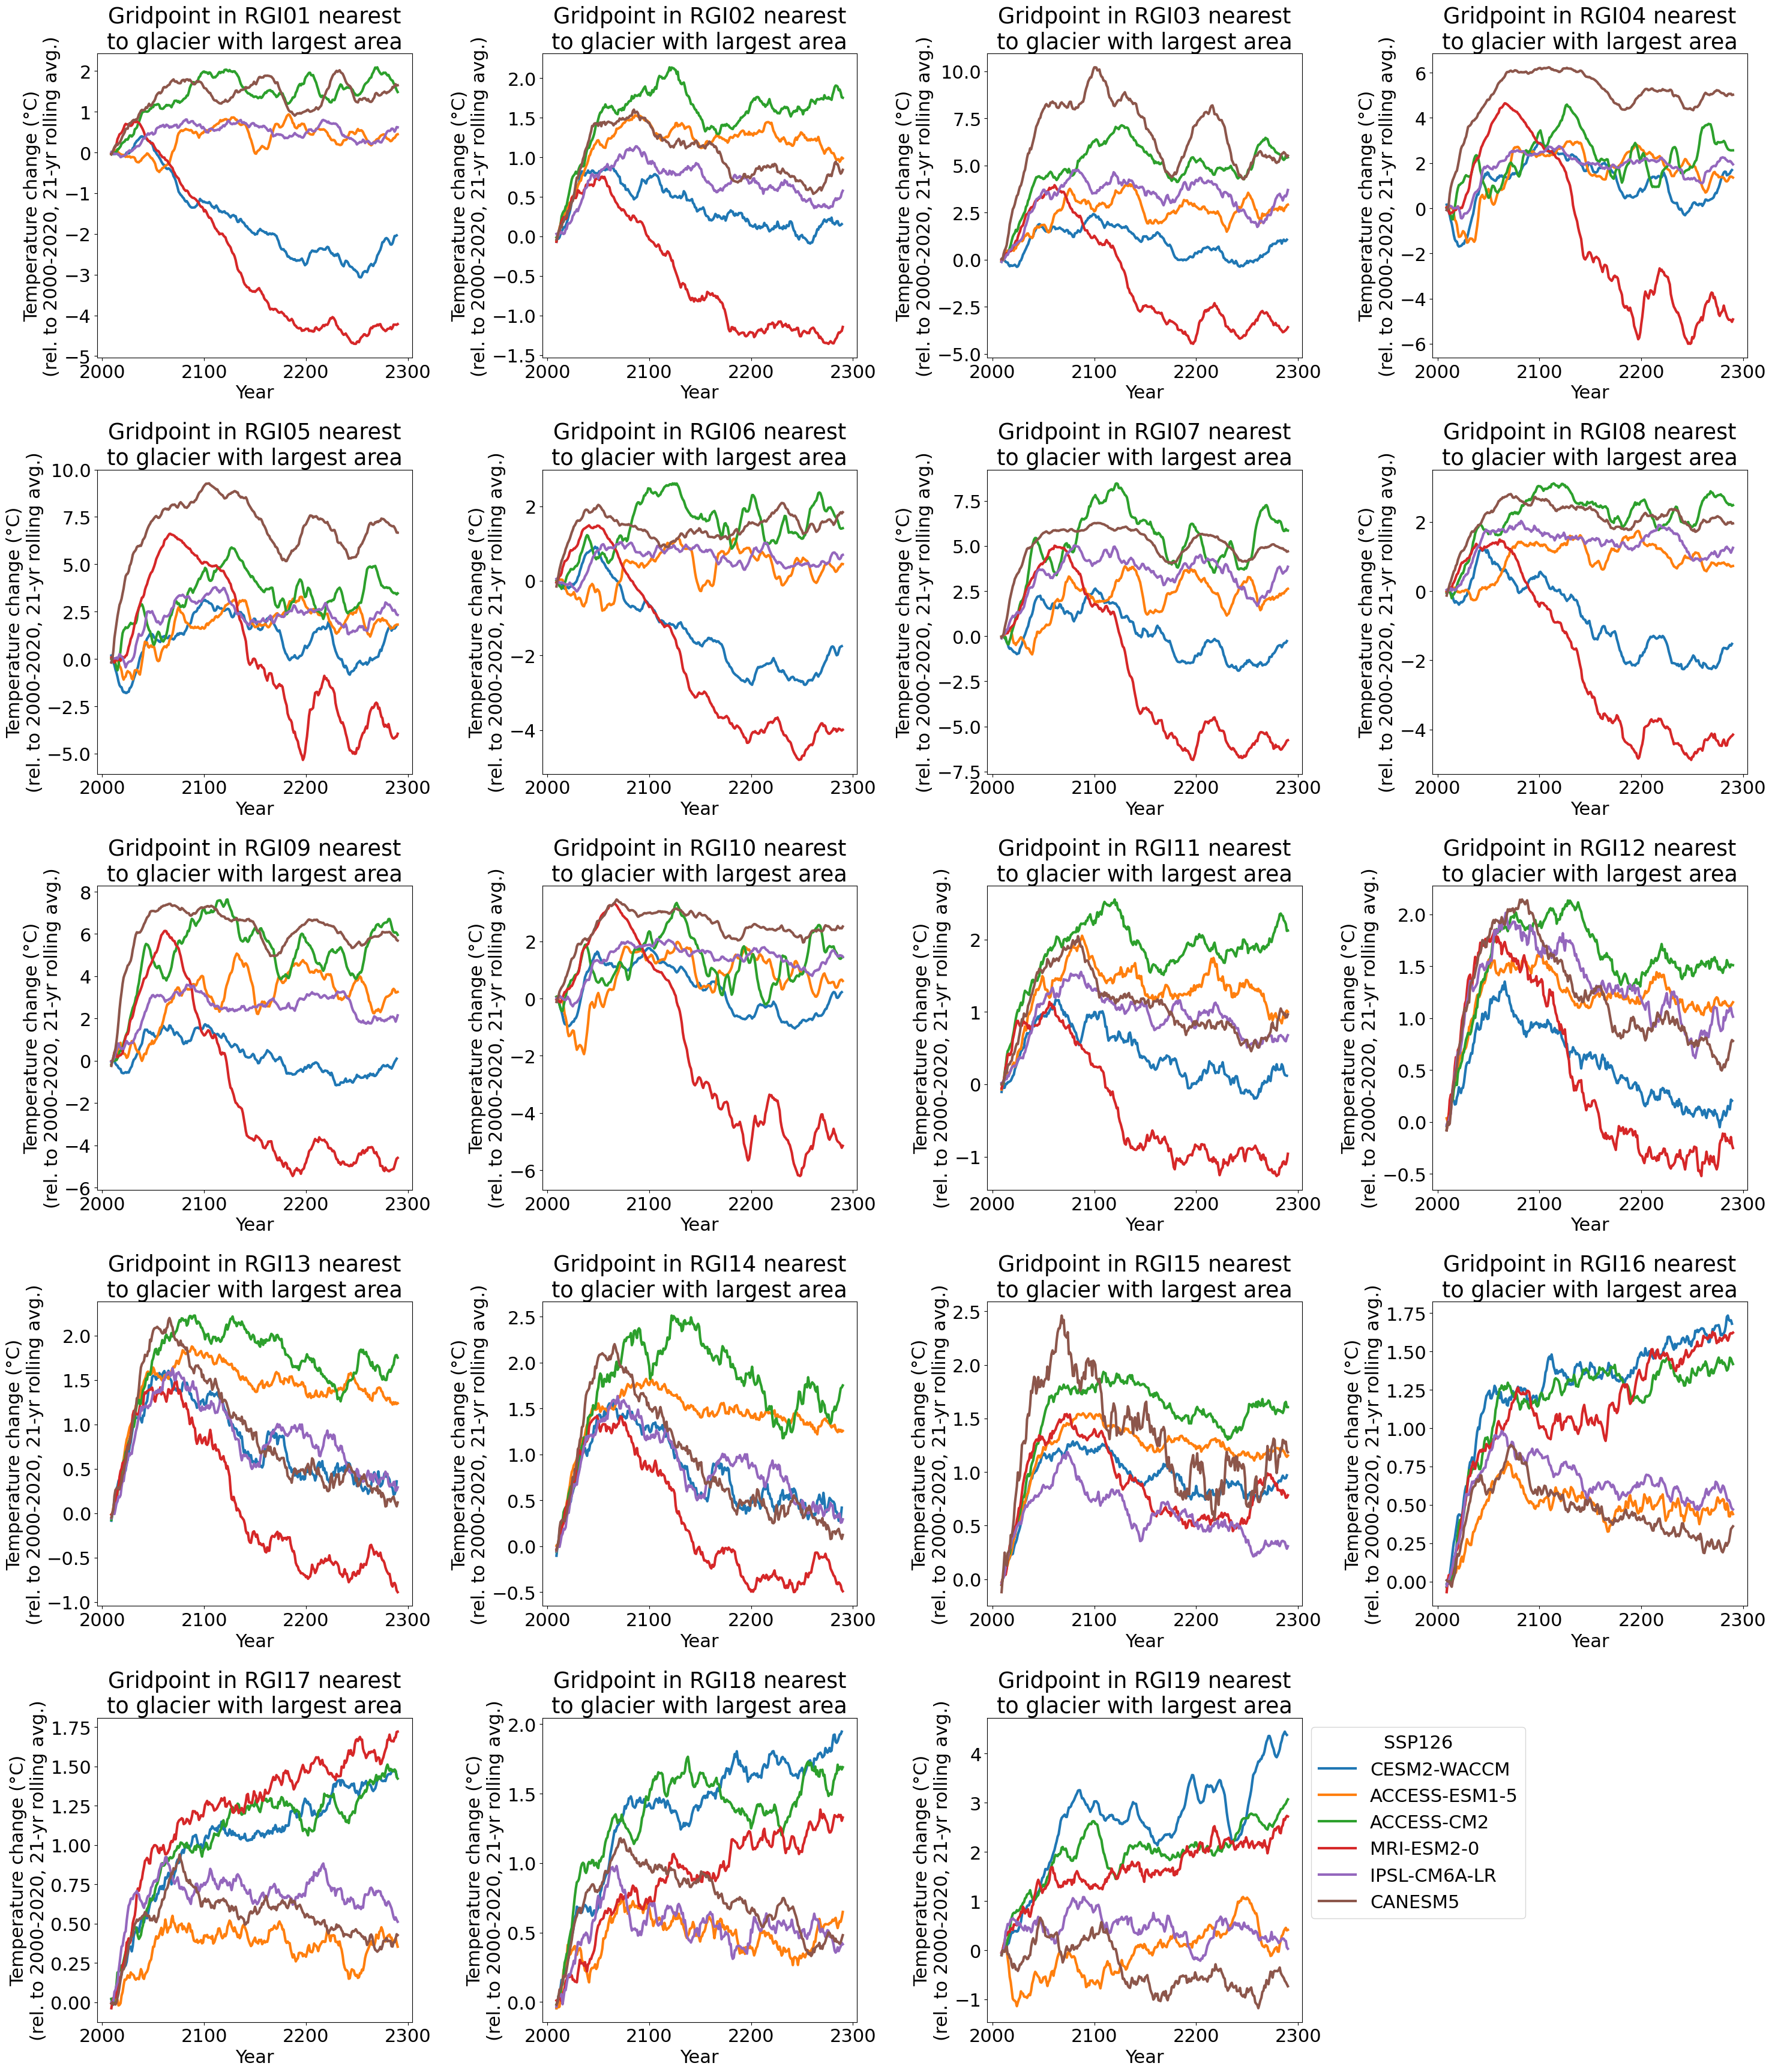

In [68]:
colors_gcm_d = {}
for jj,g in enumerate(['CESM2-WACCM', 'ACCESS-ESM1-5', 'ACCESS-CM2', 'MRI-ESM2-0',  'IPSL-CM6A-LR','CANESM5']):
    colors_gcm_d[g] = f'C{jj}'
plt.rc('font', size=22)
plt.figure(figsize=(30,35))
j = 1
for region in ['RGI01','RGI02', 'RGI03',
               'RGI04','RGI05', 'RGI06',
               'RGI07','RGI08', 'RGI09',
               'RGI10','RGI11', 'RGI12',
               'RGI13','RGI14', 'RGI15',
              'RGI16','RGI17', 'RGI18','RGI19']:
    plt.subplot(5,4,j)
    rgi = region[3:]
    CenLon, CenLat = odf.loc[odf.O1Region == f'{rgi}'].sort_values(by='Area').iloc[0][['CenLon','CenLat']].values

    for gcm in colors_gcm_d.keys():
        #if gcms_cmip6_2300_over.loc[f].folder == 'IPSL-CM6A-LR':
        #gcm = gcms_cmip6_2300_over.loc[f].folder
        dtas_annual = dtas_annual_d_ssp126[gcm]
        sel_rgi = dtas_annual.sel(lat = CenLat, lon = CenLon, method='nearest').sel(year=slice('1999', '2300')).rolling(year=21, center=True).mean()
        plt.plot(sel_rgi.year, sel_rgi.values-sel_rgi.sel(year=2010).values, label = gcm, color = colors_gcm_d[gcm.upper()], lw=3)
        #plt.title(f.folder)
    j +=1
    plt.title(f'Gridpoint in RGI{rgi} nearest\nto glacier with largest area')
    plt.ylabel('Temperature change (°C)\n(rel. to 2000-2020, 21-yr rolling avg.)')
    plt.xlabel('Year')
plt.tight_layout()
plt.legend(title='SSP126', bbox_to_anchor = (1,1), loc = 'upper left')


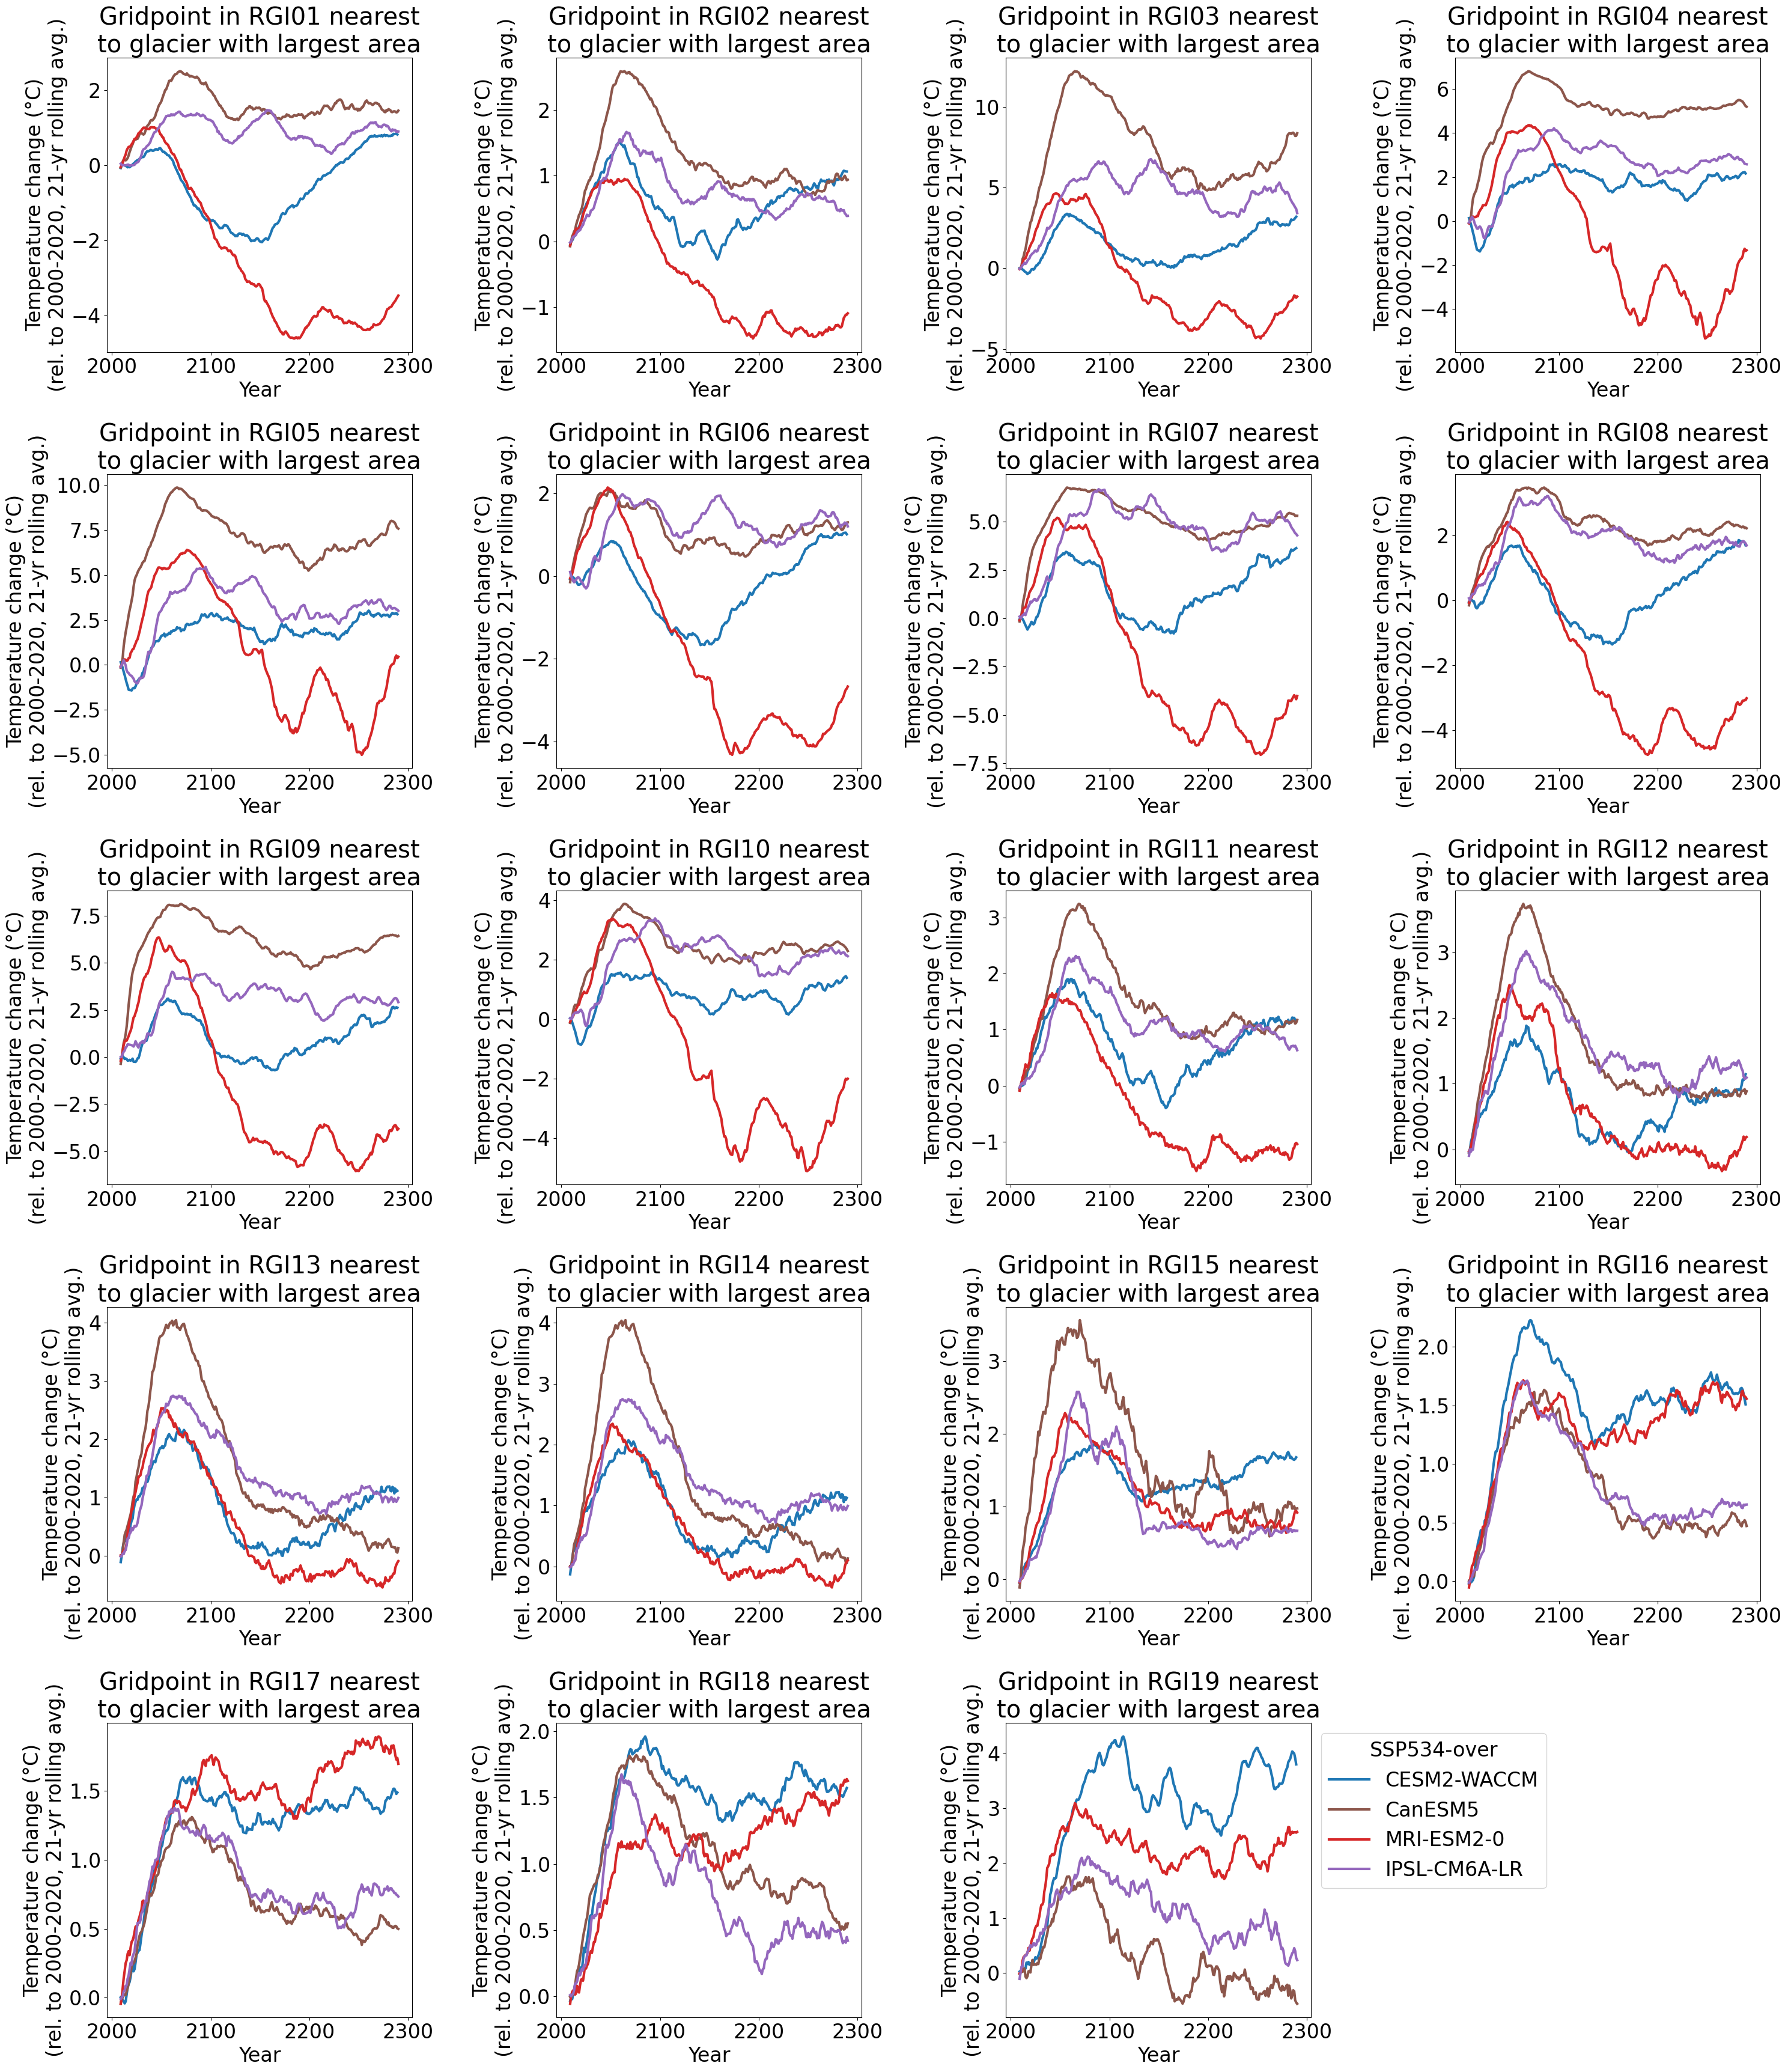

In [66]:
gcm_ssp_534_over = ['CESM2-WACCM', 'CanESM5','MRI-ESM2-0','IPSL-CM6A-LR']

plt.rc('font', size=24)
plt.figure(figsize=(30,35))
j = 1
for region in ['RGI01','RGI02', 'RGI03',
               'RGI04','RGI05', 'RGI06',
               'RGI07','RGI08', 'RGI09',
               'RGI10','RGI11', 'RGI12',
               'RGI13','RGI14', 'RGI15',
              'RGI16','RGI17', 'RGI18','RGI19']:
    plt.subplot(5,4,j)
    rgi = region[3:]
    CenLon, CenLat = odf.loc[odf.O1Region == f'{rgi}'].sort_values(by='Area').iloc[0][['CenLon','CenLat']].values

    for gcm in gcm_ssp_534_over:
        #if gcms_cmip6_2300_over.loc[f].folder == 'IPSL-CM6A-LR':
        #gcm = gcms_cmip6_2300_over.loc[f].folder
        dtas_annual = dtas_annual_d_ssp534_over[gcm.upper()]
        sel_rgi = dtas_annual.sel(lat = CenLat, lon = CenLon, method='nearest').sel(year=slice('1999', '2300')).rolling(year=21, center=True).mean()
        plt.plot(sel_rgi.year, sel_rgi.values-sel_rgi.sel(year=2010).values, label = gcm,color = colors_gcm_d[gcm.upper()], lw=3)
        #plt.title(f.folder)
    j +=1
    plt.title(f'Gridpoint in RGI{rgi} nearest\nto glacier with largest area')
    plt.ylabel('Temperature change (°C rel. to 2000-2020, 21-yr rolling avg.)')
    plt.ylabel('Temperature change (°C)\n(rel. to 2000-2020, 21-yr rolling avg.)')

    plt.xlabel('Year')
plt.tight_layout()
plt.legend(title='SSP534-over', bbox_to_anchor = (1,1), loc = 'upper left')


In [164]:
### trial code which does not work at the moment:
## get a mask for every RGI region 
ds_ref = xr.open_dataset(gcms_cmip6_2300_over.iloc[0]['path'], use_cftime=True)
#ds_ref = ds_ref.isel(lat=slice(1,-1))
ds_ref['test_values']  = (ds_ref.tas/ds_ref.tas).mean(dim='time')
max_lat = np.unique((ds_ref.lat.values[1:]-ds_ref.lat.values[:-1])/2)[0]
max_lon = np.unique(ds_ref.lon.values[1:] - ds_ref.lon.values[:-1])[0]/2
print(max_lat, max_lon)
ds_ref.coords['lon'] = np.where(ds_ref.lon.values < 0,
                                      ds_ref.lon.values + 360,
                                     ds_ref.lon.values)
ds_ref = ds_ref.sortby(ds_ref.lon)
ds_ref.lon.attrs['units'] = 'degrees_onlypositive'

# get the dataset where coordinates of glaciers are stored
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)

nx, ny = ds_ref.dims['lon'], ds_ref.dims['lat']
# just make them into 0-> 360 scheme
cenlon_for_bins = np.where(odf['CenLon'] < 0,
                           odf['CenLon']+360, odf['CenLon'])
#cenlon_for_bins = odf['CenLon']

# Nearest neighbor lookup
lon_bins = np.linspace(ds_ref.lon.data[0] - max_lon, ds_ref.lon.data[-1] + max_lon +1, nx) ##attential experimental, removed nx+1
lon_bins = ds_ref.lon_bnds.values.flatten()[::2]
# !!! attention W5E5 sorted from 90 to -90 !!!!
lat_bins = np.linspace(ds_ref.lat.data[0] - max_lat, ds_ref.lat.data[-1] + max_lat, ny+1)
# before it was wrongly 
# lon_bins = np.linspace(0, 360, nx), lat_bins = np.linspace(90, -90, ny)
# which created a non-aligned bins, in addition there was one bin missing, creating a slightly 
# larger resolution which after adding up a lot got problematic... 
# at the end it resulted in 19 glaciers where the nearest grid point was not found

odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1
# this does not work, can that be removed???
odf['lon_val'] = ds_ref.lon.data[odf.lon_id]
odf['lat_val'] = ds_ref.lat.data[odf.lat_id]
# Use unique grid points as index and compute the area per location
odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]
mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
mdf['Area'] = odf.groupby('unique_id').sum()['Area']
print('Total number of glaciers: {} and number of GCM gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))

# this is the mask that we need to remove all non-glacierized gridpoints
mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['Area'] # 1
ds_ref['glacier_mask'] = (('lat', 'lon'), np.isfinite(mask))

# check the distance to the gridpoints-> it should never be larger than 
diff_lon = ds_ref.lon.data[odf.lon_id] - odf.CenLon
# if the distance is 360 -> it is the same as 0,
diff_lon = np.where(np.abs(diff_lon - 360) < 170, diff_lon-360, diff_lon)
odf['ll_dist_to_point'] = ((diff_lon)**2 + (ds_ref.lat.data[odf.lat_id] - odf.CenLat)**2)**0.5
assert odf['ll_dist_to_point'].max() < (max_lon**2 + max_lat**2)**0.5
# just select the glacier_mask variable:
ds_ref = ds_ref.drop_vars(['time_bnds','tas']).drop_dims('time')

ds_ref['glacier_area'] = (('lat', 'lon'), mask)
ds_ref['weight_glacier'] = (('lat', 'lon'), mask / np.nansum(mask))

reg = np.full((ny, nx), np.NaN)
reg[mdf['lat_id'], mdf['lon_id']] = mdf['O1Region'].astype(int)
ds_ref['rgi_region'] = (('lat', 'lon'), reg)

# Normal Weight
weight = np.cos(np.deg2rad(ds_ref.lat.astype(np.float64))).clip(0)
weight =  ds_ref.test_values * 0. + weight
ds_ref['weight'] = (('lat', 'lon'), weight.values / weight.sum().values)

# weighted average over latitudes
weight_regions = {}
weight_regions['global'] = ds_ref.weight  ##.sum(dim='lon')

# this is glacier area weighted
weight_regions['global_glacier']  = ds_ref.weight_glacier  ##.sum(dim='lon')
for rgi_reg in range(1, 20):
    weight_reg = ds_ref.weight_glacier.where(ds_ref.rgi_region == rgi_reg)
    weight_reg = weight_reg / weight_reg.sum()
    weight_regions[f'RGI{rgi_reg:02g}_glacier'] = weight_reg  ##.sum(dim='lon')
regions = weight_regions.keys()

1.3836359254576394 1.40625
Total number of glaciers: 216502 and number of GCM gridpoints with glaciers in them: 591


AssertionError: 

In [ ]:
l_pd_clim_glob_basin = []
    for scenario in ['stab_T12','stab_T15','oversh_T20OS15','oversh_T25OS15',
                     'oversh_T30OS15','stab_T20','stab_T25','stab_T30']:
        
        for region in regions:
            weight_sel = weight_regions[region]
            np.testing.assert_allclose(weight_sel.sum(),1)
            _pd_clim_glob_basin = pd.DataFrame(index=np.arange(1979,2500,1))

            dg_tas = xr.open_dataset(f'{path}/{scenario}/scenario_tas_annual.nc').t_ref
            global_dtas = (dg_tas * weight_sel).sum(dim='lon').sum(dim='lat')
            dg_precip = xr.open_dataset(f'{path}/{scenario}/scenario_precip_annual.nc').precip
            global_dprecip = (dg_precip * weight_sel).sum(dim='lon').sum(dim='lat')
            _pd_clim_glob_basin.loc[global_dtas.year,'temp'] = global_dtas.values
            _pd_clim_glob_basin['temp_20yr_avg'] = _pd_clim_glob_basin['temp'].rolling(20, center=True).mean()
            _pd_clim_glob_basin.loc[global_dtas.year,'precip'] = global_dprecip.values
            _pd_clim_glob_basin['precip_20yr_avg'] = _pd_clim_glob_basin['precip'].rolling(20, center=True).mean()
            _pd_clim_glob_basin.loc[global_dtas.year,'region'] = region
            _pd_clim_glob_basin.loc[global_dtas.year,'scenario'] = scenario
            _pd_clim_glob_basin.loc[global_dtas.year,'year'] = global_dtas.year.values
            l_pd_clim_glob_basin.append(_pd_clim_glob_basin)
    pd_clim_glob_rgi_reg = pd.concat(l_pd_clim_glob_basin).reset_index()
    pd_clim_glob_rgi_reg['year'] = pd_clim_glob_rgi_reg.year.astype(int).values
    pd_clim_glob_rgi_reg = pd_clim_glob_rgi_reg.drop(columns='index')
    #pd_clim_glob_rgi_reg.to_csv('annual_glob_glacier_rgi_reg_temp_precip_timeseries_oversh_stab.csv')